### This recommendation system was developed by:
### - Nehaa Nayaana Amar Raj S10256085B
### - Arienne Chin S10256994E

# 1. Load and Explore the data

## 1.1 Import the libraries

In [1]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps
import numpy as np
from sklearn.pipeline import Pipeline
import feature_engine.imputation as mdi
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from bs4 import BeautifulSoup
from googletrans import Translator
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import pickle
from scipy.sparse import save_npz
import pandas as pd
import matplotlib.pyplot as plt


## 1.2 Import the dataset

- Done by Nehaa Nayaana Amar Raj

In [2]:
conn = ps.connect(dbname="postgres",
                   user="postgres",
                   password="postgres",
                   host = "localhost",
                    port="5432")

In [3]:
# Fetch data from the database
sql_area = """SELECT * FROM public.area"""
sql_farm = """SELECT * FROM public.farm"""
sql_product = """SELECT * FROM public.product"""
sql_sale_order = """SELECT * FROM public.sale_order"""
sql_sale_order_item = """SELECT * FROM public.sale_order_item"""

In [4]:
# Convert to DataFrame
df_area = pd.read_sql(sql_area, conn)
df_farm = pd.read_sql(sql_farm, conn)
df_product = pd.read_sql(sql_product, conn)
df_sale_order = pd.read_sql(sql_sale_order, conn)
df_sale_order_item = pd.read_sql(sql_sale_order_item, conn)

C:\Users\nehaa\AppData\Local\Temp\ipykernel_8900\3184278191.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_area = pd.read_sql(sql_area, conn)
C:\Users\nehaa\AppData\Local\Temp\ipykernel_8900\3184278191.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_farm = pd.read_sql(sql_farm, conn)
C:\Users\nehaa\AppData\Local\Temp\ipykernel_8900\3184278191.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_product = pd.read_sql(sql_product, conn)
C:\Users\nehaa\AppData\Local\Temp\ipykernel_8900\3184278191.py:5: UserWar

## 1.3 Show and merge the data into 2 master dataframes

- Done by Arienne Chin

### 1.3.1 df_area

- Done by Arienne Chin

In [5]:
# df_area
df_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 46 non-null     object 
 1   name               46 non-null     object 
 2   level_0            46 non-null     object 
 3   level_1            46 non-null     object 
 4   level_2            46 non-null     object 
 5   level_3            46 non-null     object 
 6   level_3_latitude   46 non-null     float64
 7   level_3_longitude  46 non-null     float64
 8   level_4            46 non-null     object 
 9   level_4_latitude   46 non-null     float64
 10  level_4_longitude  46 non-null     float64
dtypes: float64(4), object(7)
memory usage: 4.1+ KB


In [6]:
# update the df_area columns for readability
df_area = df_area.rename(columns={'id': 'area_id', 'name': 'area_name', 'level_0': 'country', 'level_1': 'province', 'level_2': 'city', 
                                  'level_3': 'district', 'level_3_latitude': 'district_latitude', 'level_3_longitude': 'district_longitude', 
                                  'level_4': 'subdistrict', 'level_4_latitude': 'subdistrict_latitude', 
                                  'level_4_longitude': 'subdistrict_longitude'})

### 1.3.2 df_farm

- Done by Arienne Chin

In [7]:
# df_farm
df_farm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      100 non-null    object 
 1   owner_id                100 non-null    object 
 2   area_id                 100 non-null    object 
 3   latitude                2 non-null      float64
 4   longitude               2 non-null      float64
 5   area_hectare            100 non-null    float64
 6   planted_year            100 non-null    int64  
 7   planted_month           100 non-null    int64  
 8   palm_trees_per_hectare  48 non-null     float64
 9   soil_type               100 non-null    object 
 10  seed_type               28 non-null     object 
dtypes: float64(4), int64(2), object(5)
memory usage: 8.7+ KB


In [8]:
# update the df_farm columns for readability
df_farm = df_farm.rename(columns={'id': 'farm_id', 'latitude': 'farm_latitude', 'longitude': 'farm_longitude'})

### 1.3.3 Merge df_area & df_farm into df_product

- Done by Arienne Chin

In [9]:
# check df_area & df_farm for overlaps

# Extract farm_ids from both DataFrames
set1 = set(df_area['area_id'])
set2 = set(df_farm['area_id'])

# Find overlapping farm_ids
overlap = set1.intersection(set2)
print("Overlap count:", len(overlap))
print("Overlap farm_ids:", overlap)

Overlap count: 46
Overlap farm_ids: {'ID1210092001', 'ID1220082034', 'ID1223032007', 'ID1101032013', 'ID1223052007', 'ID1674032004', 'ID1102022015', 'ID1223012005', 'ID1223052006', 'ID1222052002', 'ID1505011003', 'ID3211012006', 'ID1471041002', 'ID1505012007', 'ID1508121001', 'ID1209212006', 'ID1223052018', 'ID1709042007', 'ID1205202006', 'ID1205052007', 'ID1222052003', 'ID3173051001', 'ID1509011001', 'ID1102032026', 'ID1508092014', 'ID3529062001', 'ID1508092008', 'ID1223052010', 'ID1601322001', 'ID1802102003', 'ID1209182011', 'ID1205202005', 'ID1205012003', 'ID1401172001', 'ID1303092002', 'ID1508092011', 'ID1101142007', 'ID1207242015', 'ID1507091001', 'ID1901082004', 'ID1901042008', 'ID1407131002', 'ID1205012002', 'ID1205201001', 'ID1504021002', 'ID1205012012'}


In [10]:
# merge df_area & df_farm
df = pd.merge(df_area, df_farm, on='area_id', how='inner')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   area_id                 100 non-null    object 
 1   area_name               100 non-null    object 
 2   country                 100 non-null    object 
 3   province                100 non-null    object 
 4   city                    100 non-null    object 
 5   district                100 non-null    object 
 6   district_latitude       100 non-null    float64
 7   district_longitude      100 non-null    float64
 8   subdistrict             100 non-null    object 
 9   subdistrict_latitude    100 non-null    float64
 10  subdistrict_longitude   100 non-null    float64
 11  farm_id                 100 non-null    object 
 12  owner_id                100 non-null    object 
 13  farm_latitude           2 non-null      float64
 14  farm_longitude          2 non-null      flo

In [11]:
# df_product
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   41 non-null     object 
 1   sku                  41 non-null     object 
 2   type                 41 non-null     object 
 3   unit_of_measurement  41 non-null     object 
 4   name                 41 non-null     object 
 5   price                41 non-null     float64
 6   description          41 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.4+ KB


In [12]:
# update the df_product columns for readability
df_product = df_product.rename(columns={'id': 'product_id', 'sku': 'product_sku', 'type': 'product_type', 'name': 'product_name', 
                                        'price': 'product_price', 'description': 'product_description'})

### 1.3.4 df_sale_order

- Done by Arienne Chin

In [13]:
# df_sale_order
df_sale_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                100 non-null    object 
 1   user_id           100 non-null    object 
 2   total_item_price  100 non-null    float64
 3   created_at_utc0   100 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.3+ KB


In [14]:
# update the df_sale_order columns for readability
df_sale_order = df_sale_order.rename(columns={'id': 'sale_order_id', 'created_at_utc0': 'time_of_sale'})

### 1.3.5 df_sale_order_item

- Done by Arienne Chin

In [15]:
# df_sale_order_item
df_sale_order_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             116 non-null    object 
 1   sale_order_id  116 non-null    object 
 2   product_id     116 non-null    object 
 3   quantity       116 non-null    int64  
 4   price          116 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.7+ KB


In [16]:
# update the df_sale_order_item columns for readability
df_sale_order_item = df_sale_order_item.rename(columns={'id': 'farm_id'})

### 1.3.6 Merge df_sale_order_item & df_sale_order into df_sale_order_item

- Done by Arienne Chin

In [17]:
# check df_sale_order_item & df_sale_order for overlaps

# Extract farm_ids from both DataFrames
set1 = set(df_sale_order_item['sale_order_id'])
set2 = set(df_sale_order['sale_order_id'])

# Find overlapping farm_ids
overlap = set1.intersection(set2)
print("Overlap count:", len(overlap))
print("Overlap farm_ids:", overlap)

Overlap count: 100
Overlap farm_ids: {'fd17275e-5946-42dd-9cb8-205061715f67', '72b873a9-54d2-45da-8fb9-92f48d509c52', '5ae30247-0799-447f-87bd-cb836df433e4', 'a1688ca7-4123-4d2a-8ef4-44a0be1580a1', '86ec48cf-8e0f-4267-be17-fba2c7220d0c', 'f2339ba3-ceeb-4a35-a19b-27bc13e89698', '86496962-031e-4f39-a78c-dd907bcd7322', 'b079c590-e0df-4952-9b5e-6d1a9137fc58', 'afbf2c98-e8e6-4ca7-acf3-af3958dfe34f', '20f151bd-8ad2-4fba-8e33-e900d8036701', '29ae89fb-8d2b-42d7-b985-6e8d9db17bc5', '0beaeb7f-53c8-45de-a937-ad9e12d882c4', '8bfc45e8-a86d-4821-a0ee-1404fbcf8d69', '887c9ab7-c86b-44fd-8623-640028926faf', '242572c5-55b4-40e8-9b35-1c25474b6136', 'b5b9c2a8-257c-42b4-a102-ca88e4d90297', '787bc8b7-e679-4772-be5d-af4afac9adf5', '25c230cb-5762-4859-8525-db540f4f9bf3', '6b843a88-fa74-42b1-a8e8-2c8cbe09cc86', '63df6a83-0a96-4fd0-9942-79049353afd0', '48620ebf-ee8f-468e-931d-492f9b94690b', '6090bbb6-c528-4223-af54-72394b4166bb', 'd8255d29-c3ce-4b4e-8b0a-3e0b053ab58a', '4346187f-5f63-4d5f-8d12-b494143bce30', '9

In [18]:
# merge df_sale_order_item & df_sale_order
df_sale = pd.merge(
    df_sale_order_item,
    df_sale_order,
    on='sale_order_id',
    how='inner'
)

df_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   farm_id           116 non-null    object 
 1   sale_order_id     116 non-null    object 
 2   product_id        116 non-null    object 
 3   quantity          116 non-null    int64  
 4   price             116 non-null    float64
 5   user_id           116 non-null    object 
 6   total_item_price  116 non-null    float64
 7   time_of_sale      116 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 7.4+ KB


In [19]:
# check df_sale & df_product for overlaps

# Extract farm_ids from both DataFrames
set1 = set(df_sale['product_id'])
set2 = set(df_product['product_id'])

# Find overlapping farm_ids
overlap = set1.intersection(set2)
print("Overlap count:", len(overlap))
print("Overlap farm_ids:", overlap)

Overlap count: 41
Overlap farm_ids: {'1033503b-8faa-4d5c-97c2-50bb19fbb897', '2b8fe2f0-5d07-459c-8781-22305a61980a', 'c7768e6d-d8d9-469f-960d-879b5401d83c', 'af58006e-c0d7-44ec-9089-609b74e9ece2', '8acff85f-f70a-4308-801f-763b22bb25c7', 'c1d06ac3-5bea-4b4d-8648-ae3fa531f059', 'c2b3d62f-6c48-4051-beb1-3ec66d30c1da', 'e8898291-543b-439c-907f-bd80075f02a0', 'd3999f4e-890a-473f-bb92-2fd2178da3fb', '4698d965-a133-4701-838b-f60e38c66b39', 'a48adaed-ab06-4245-8da6-5d560636a1d9', '0bd2430a-6613-442a-9d5a-11d64cb095ae', '76fddc47-aea9-4942-9dbd-19d90f31cdd4', '5110ed03-9e1e-44bd-913c-4f56de2dcf0b', 'beb17fe4-5d92-4738-adaa-2d62ffb83516', '9e7cc609-f4ef-4246-89e7-756861e623d8', 'e41e1522-bbe0-4e9b-b638-5470e82e13a5', 'c5e57af4-0df9-4e2b-87e4-9024b8e6cf53', 'ff58b8c4-1058-4753-bfc0-c04d091c8485', '5501ce77-7a08-4086-8dda-858c92326fc6', '8152e395-0f7a-4dda-8df9-6655a726c4e1', '701928af-24e9-4a13-aaad-63ede44be9c8', 'fc02857f-92ea-48a1-96b5-95acf43b922e', '944f4171-813b-4423-ad89-3c73d67f9986', '8f

In [20]:
# merge df_sale & df_product
df_sale = pd.merge(
    df_sale,
    df_product,
    on='product_id',
    how='inner'
)

df_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   farm_id              116 non-null    object 
 1   sale_order_id        116 non-null    object 
 2   product_id           116 non-null    object 
 3   quantity             116 non-null    int64  
 4   price                116 non-null    float64
 5   user_id              116 non-null    object 
 6   total_item_price     116 non-null    float64
 7   time_of_sale         116 non-null    int64  
 8   product_sku          116 non-null    object 
 9   product_type         116 non-null    object 
 10  unit_of_measurement  116 non-null    object 
 11  product_name         116 non-null    object 
 12  product_price        116 non-null    float64
 13  product_description  116 non-null    object 
dtypes: float64(3), int64(2), object(9)
memory usage: 12.8+ KB


### 1.3.7 Display the 2 master dataframes

- Done by Arienne Chin

In [21]:
# display df_farm
df_farm = df
df_farm.info()
df_farm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   area_id                 100 non-null    object 
 1   area_name               100 non-null    object 
 2   country                 100 non-null    object 
 3   province                100 non-null    object 
 4   city                    100 non-null    object 
 5   district                100 non-null    object 
 6   district_latitude       100 non-null    float64
 7   district_longitude      100 non-null    float64
 8   subdistrict             100 non-null    object 
 9   subdistrict_latitude    100 non-null    float64
 10  subdistrict_longitude   100 non-null    float64
 11  farm_id                 100 non-null    object 
 12  owner_id                100 non-null    object 
 13  farm_latitude           2 non-null      float64
 14  farm_longitude          2 non-null      flo

,area_id,area_name,country,province,city,district,district_latitude,district_longitude,subdistrict,subdistrict_latitude,...,farm_id,owner_id,farm_latitude,farm_longitude,area_hectare,planted_year,planted_month,palm_trees_per_hectare,soil_type,seed_type
0,ID1101032013,"Ujung Pasir, Kluet Selatan, Aceh Selatan, Aceh",Indonesia,Aceh,Aceh Selatan,Kluet Selatan,3.05166,97.45977,Ujung Pasir,3.079105,...,f9896038-ddeb-4a63-bfb5-bfc35f9accd0,5adfd8d9-7a11-455b-90e8-62d22eb4fe91,NaN,NaN,1.0,2025,4,4.0,Mineral,SEM
1,ID1101032013,"Ujung Pasir, Kluet Selatan, Aceh Selatan, Aceh",Indonesia,Aceh,Aceh Selatan,Kluet Selatan,3.05166,97.45977,Ujung Pasir,3.079105,...,b61a9182-e109-42e3-8556-c22f4c88dab0,8c0e41e7-7a5f-4ff1-b42e-55aa219441d3,NaN,NaN,1.0,2025,4,NaN,Mineral,Dami Mas
2,ID1101142007,"Pucuk Lembang, Kluet Timur, Aceh Selatan, Aceh",Indonesia,Aceh,Aceh Selatan,Kluet Timur,3.17104,97.45977,Pucuk Lembang,3.161074,...,d231eb01-bc2c-46a6-a69a-adfb3c22988e,19d2c440-c133-49a9-9f42-de81b4938449,NaN,NaN,3000.0,2018,4,120.0,Mineral,Socfindo
3,ID1102022015,"Suka Maju, Lawe Sigala-Gala, Aceh Tenggara, Aceh",Indonesia,Aceh,Aceh Tenggara,Lawe Sigala-Gala,3.35698,97.92660,Suka Maju,3.356778,...,e7a8893a-e765-437a-a5d9-838274ee2419,dfa538d5-12f4-4a1f-b4e5-fadf961f9c36,NaN,NaN,1.0,2009,5,NaN,Mineral,None
4,ID1102022015,"Suka Maju, Lawe Sigala-Gala, Aceh Tenggara, Aceh",Indonesia,Aceh,Aceh Tenggara,Lawe Sigala-Gala,3.35698,97.92660,Suka Maju,3.356778,...,6807037a-f75c-4f34-9814-5b19e59c0d4a,6ff1149e-cd24-40f7-8170-37cfe02aafb0,NaN,NaN,2.0,2009,5,NaN,Mineral,None


In [22]:
# display df_sale
df_sale.info()
df_sale.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   farm_id              116 non-null    object 
 1   sale_order_id        116 non-null    object 
 2   product_id           116 non-null    object 
 3   quantity             116 non-null    int64  
 4   price                116 non-null    float64
 5   user_id              116 non-null    object 
 6   total_item_price     116 non-null    float64
 7   time_of_sale         116 non-null    int64  
 8   product_sku          116 non-null    object 
 9   product_type         116 non-null    object 
 10  unit_of_measurement  116 non-null    object 
 11  product_name         116 non-null    object 
 12  product_price        116 non-null    float64
 13  product_description  116 non-null    object 
dtypes: float64(3), int64(2), object(9)
memory usage: 12.8+ KB


,farm_id,sale_order_id,product_id,quantity,price,user_id,total_item_price,time_of_sale,product_sku,product_type,unit_of_measurement,product_name,product_price,product_description
0,d4dc9c06-177e-494c-ba72-7e2954ce8ced,3ddca641-cb59-4a27-8698-cb16ff2932f2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,200,326000.0,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...
1,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,Rock Phosphate (RP) adalah salah satu sumber f...
2,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000
3,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,<p>Kaos tidak berkerah warna Putih bertuliskan...
4,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...


## 1.4 Exploratory Data Analysis

- Done by Nehaa Nayaana Amar Raj

### 1.4.1 Univariate

- Done by Nehaa Nayaana Amar Raj

#### 1.4.1.1 df_sale

- Done by Nehaa Nayaana Amar Raj

In [23]:
df_sale.isnull().sum()


farm_id                0
sale_order_id          0
product_id             0
quantity               0
price                  0
user_id                0
total_item_price       0
time_of_sale           0
product_sku            0
product_type           0
unit_of_measurement    0
product_name           0
product_price          0
product_description    0
dtype: int64

In [24]:
df_sale.groupby('product_name')['quantity'].sum().sort_values(ascending=False).head(10)


product_name
MOP/KCL Canada Cap Mahkota 50kg           3980
Urea Nitrea 46% N 50kg                    2350
NPK Mahkota 13-8-27-4 0.5 B 50kg          1401
Urea Nitrea 46% N 50kg - Granul           1200
Bibit Topaz Siap Tanam                     900
Dolomite M-100 50kg                        400
RP Mahkota 50kg - Egypt                    223
Pupuk SawitPRO 50kg + Abu Janjang 40kg     222
NPK DGW 13-8-27-4 TE 50kg                  214
Dolomit Super Inti M-100 50kg              150
Name: quantity, dtype: int64

Text(0.5, 1.0, 'Distribution of Product Prices')

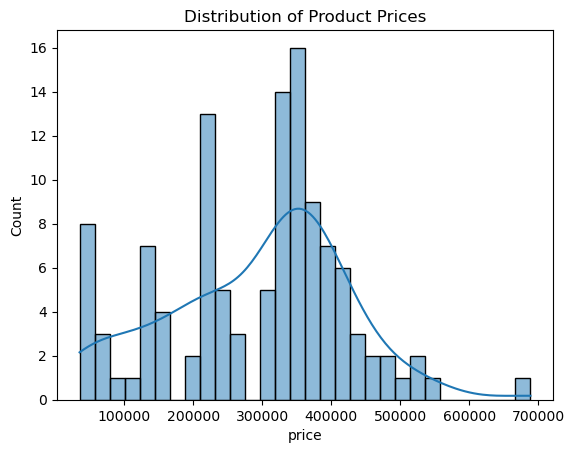

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_sale['price'], bins=30, kde=True)
plt.title("Distribution of Product Prices")


In [26]:
df_sale.groupby('product_type')['total_item_price'].sum().sort_values(ascending=False)

product_type
GOODS      4.090836e+09
DIGITAL    5.290000e+05
SERVICE    5.000000e+04
Name: total_item_price, dtype: float64

In [27]:
df_sale.groupby('user_id')['total_item_price'].sum().sort_values(ascending=False).head(5)


user_id
444d489c-eabd-4e37-b21b-d11ebeb28f9b    942430000.0
9c605d36-9c37-4f1e-bac1-c87146fae1f0    680650000.0
7a341d40-7166-46d4-b37f-be9a9ecec7f7    552250000.0
eaeb96f7-eedc-4613-a2a6-2ac88902ec62    334500000.0
e4d68529-9d3c-4db3-bc55-cc3bc3ead00f    258390000.0
Name: total_item_price, dtype: float64

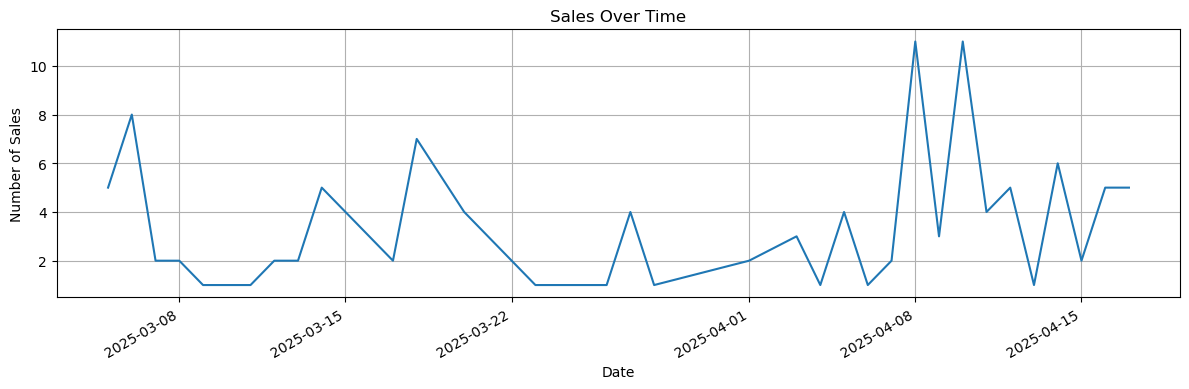

In [28]:
# convert time_of_sale from milliseconds to datetime
df_sale['sale_datetime'] = pd.to_datetime(df_sale['time_of_sale'], unit='ms')
df_sale['sale_date'] = df_sale['sale_datetime'].dt.date

# count sales per date and sort
sales_per_date = df_sale['sale_date'].value_counts().sort_index()

# convert index back to datetime for proper x-axis scaling
sales_per_date.index = pd.to_datetime(sales_per_date.index)

# plot line chart
sales_per_date.plot(kind='line', figsize=(12, 4))
plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of Quantity Sold')

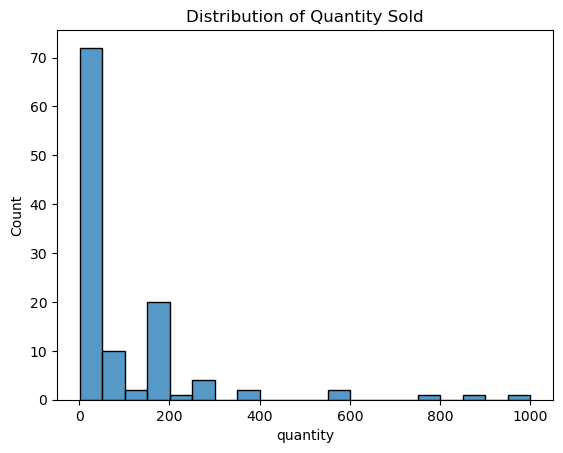

In [29]:
# distribution of quantity
sns.histplot(df_sale['quantity'], bins=20); plt.title("Distribution of Quantity Sold")

Text(0.5, 1.0, 'Product Type Count')

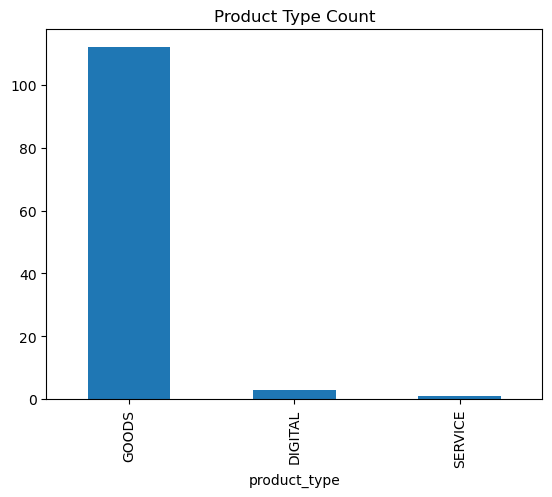

In [30]:
# product type count
df_sale['product_type'].value_counts().plot(kind='bar'); plt.title("Product Type Count")


#### 1.4.1.2 df_farm

- Done by Nehaa Nayaana Amar Raj

In [31]:
# summary statistics for numeric columns
print(df_farm.describe())

       district_latitude  district_longitude  subdistrict_latitude  \
count         100.000000          100.000000            100.000000   
mean            1.949953           99.943434              1.959663   
std             2.615673            2.634706              2.621340   
min            -7.097770           97.459770             -7.129365   
25%             1.972922           98.243170              1.938324   
50%             2.860615           98.925235              2.875050   
75%             3.805560          100.013222              3.793700   
max             3.805560          113.846580              3.847265   

       subdistrict_longitude  farm_latitude  farm_longitude  area_hectare  \
count             100.000000       2.000000        2.000000     100.00000   
mean               99.943403      -1.438965      102.842845     527.27470   
std                 2.636426       2.756875        1.986315    1851.99293   
min                97.328659      -3.388371      101.438309  

In [32]:
categorical_cols = ['country', 'province', 'city', 'district', 'subdistrict', 'soil_type', 'seed_type']
for col in categorical_cols:
    print(f"Value counts for {col}:")
    print(df_farm[col].value_counts(dropna=False))
    print("\n")

Value counts for country:
country
Indonesia    100
Name: count, dtype: int64


Value counts for province:
province
Sumatera Utara               72
Jambi                         9
Aceh                          6
Riau                          3
Sumatera Selatan              2
Kepulauan Bangka Belitung     2
Sumatera Barat                1
Bengkulu                      1
Lampung                       1
Dki Jakarta                   1
Jawa Barat                    1
Jawa Timur                    1
Name: count, dtype: int64


Value counts for city:
city
Langkat                    35
Labuhan Batu Utara         17
Deli Serdang                9
Labuhanbatu Utara           5
Bungo                       4
Aceh Tenggara               3
Aceh Selatan                3
Labuhan Batu Selatan        2
Asahan                      2
Bangka                      2
Muaro Jambi                 2
Sumedang                    1
Kota Adm. Jakarta Barat     1
Tebo                        1
Lampung Tengah           

In [33]:
num_cols = ['area_hectare', 'palm_trees_per_hectare', 'planted_year', 'planted_month']


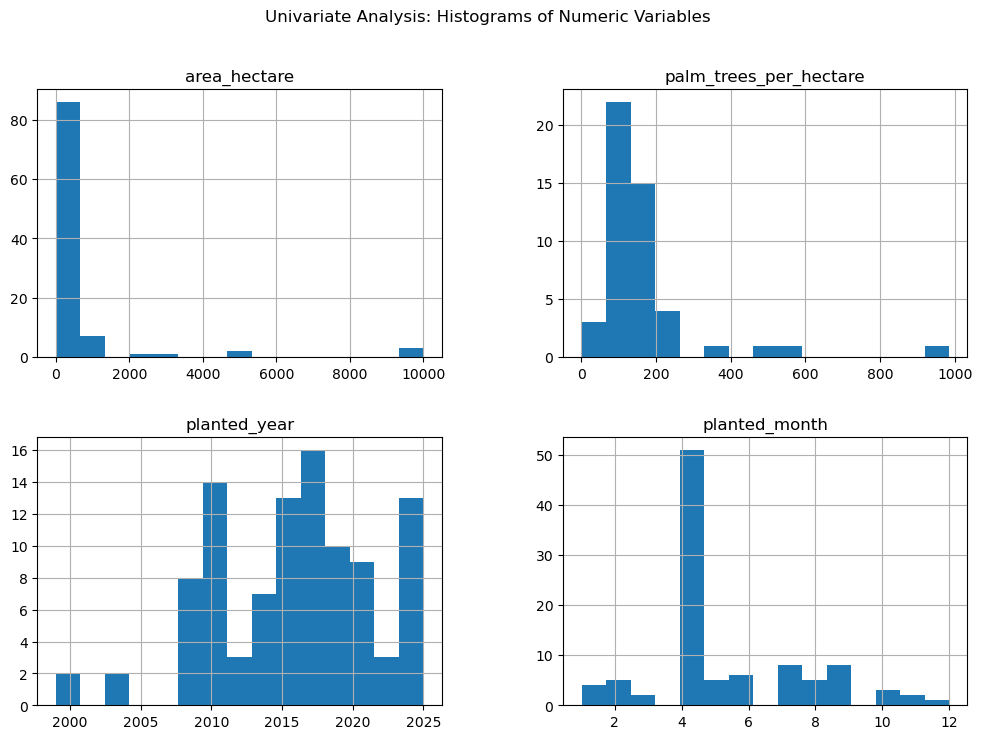

In [34]:
df_farm[num_cols].hist(bins=15, figsize=(12,8))
plt.suptitle('Univariate Analysis: Histograms of Numeric Variables')
plt.show()


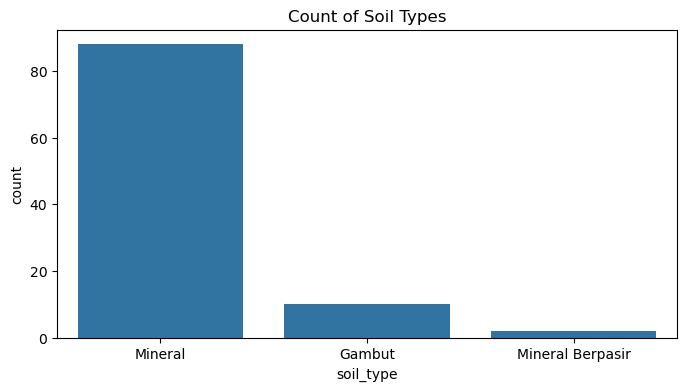

In [35]:
plt.figure(figsize=(8,4))
sns.countplot(data=df_farm, x='soil_type')
plt.title('Count of Soil Types')
plt.show()

### 1.4.2 Bivariate

- Done by Nehaa Nayaana Amar Raj

#### 1.4.2.1 df_sale

- Done by Nehaa Nayaana Amar Raj

Text(0.5, 1.0, 'Distribution of Product Prices')

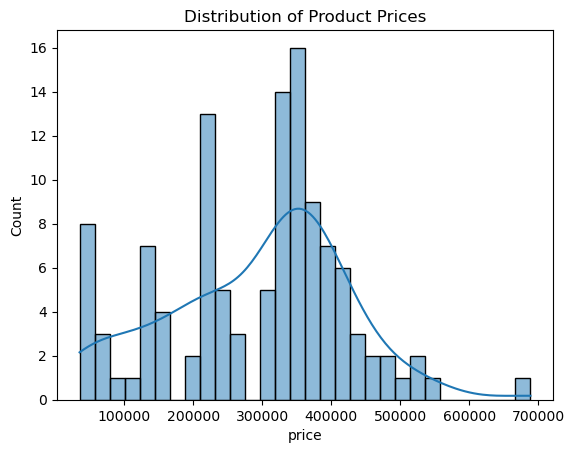

In [36]:
# price distribution
sns.histplot(df_sale['price'], bins=30, kde=True); plt.title("Distribution of Product Prices")

Text(0.5, 1.0, 'Total Item Price Distribution')

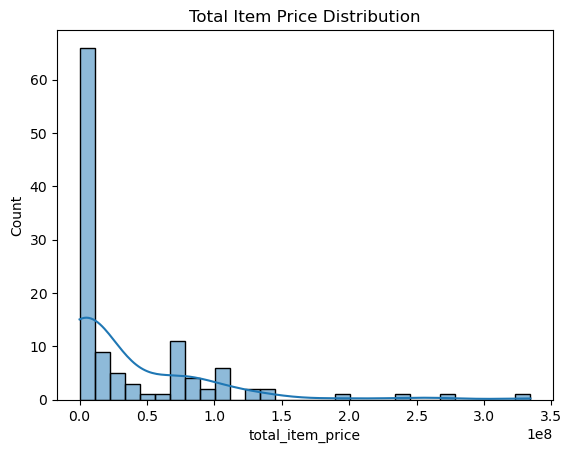

In [37]:
# total item price
sns.histplot(df_sale['total_item_price'], bins=30, kde=True); plt.title("Total Item Price Distribution")

Text(0.5, 1.0, 'Total Revenue by Product Type')

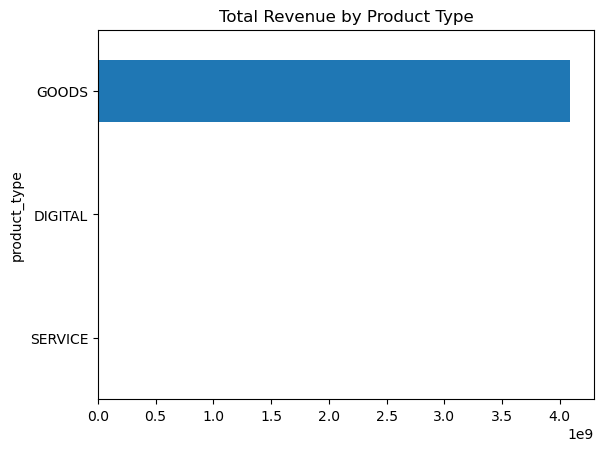

In [38]:
# product type vs total revenue
df_sale.groupby('product_type')['total_item_price'].sum().sort_values().plot(kind='barh')
plt.title("Total Revenue by Product Type")

Text(0.5, 1.0, 'Price vs Quantity Sold')

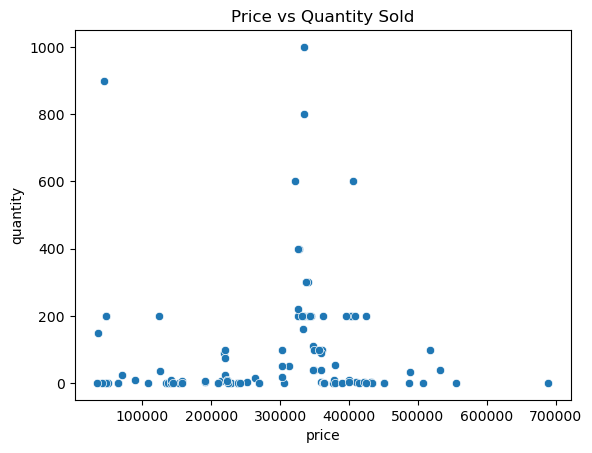

In [39]:
# quantity vs price
sns.scatterplot(data=df_sale, x='price', y='quantity')
plt.title("Price vs Quantity Sold")

#### 1.4.2.2 df_product

- Done by Nehaa Nayaana Amar Raj

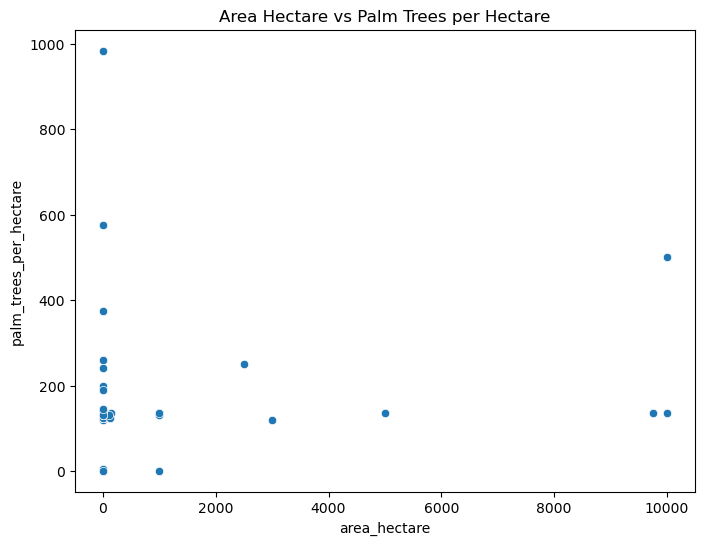

In [40]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_farm, x='area_hectare', y='palm_trees_per_hectare')
plt.title('Area Hectare vs Palm Trees per Hectare')
plt.show()

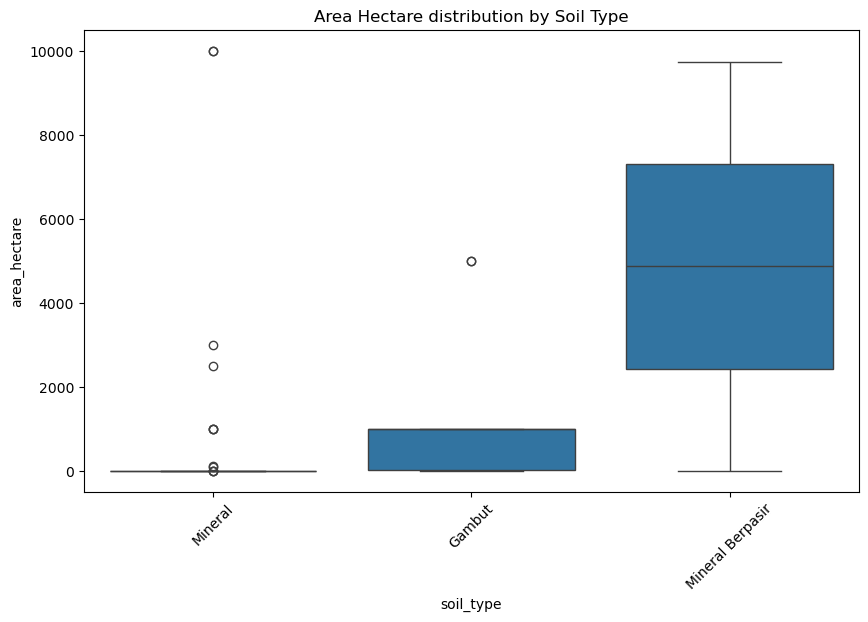

In [41]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_farm, x='soil_type', y='area_hectare')
plt.title('Area Hectare distribution by Soil Type')
plt.xticks(rotation=45)
plt.show()

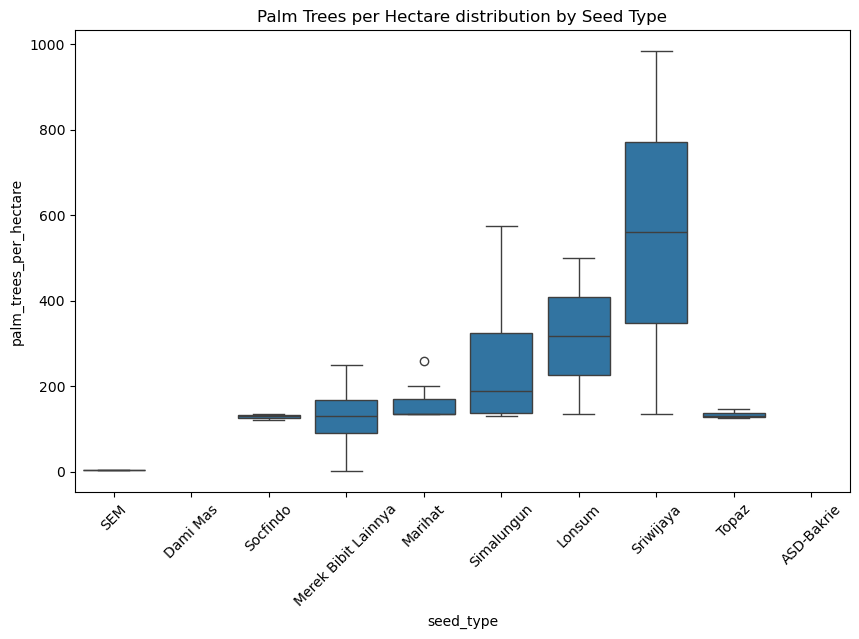

In [42]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_farm, x='seed_type', y='palm_trees_per_hectare')
plt.title('Palm Trees per Hectare distribution by Seed Type')
plt.xticks(rotation=45)
plt.show()


### 1.4.3 Multivariate

- Done by Nehaa Nayaana Amar Raj

#### 1.4.3.1 df_sale

- Done by Nehaa Nayaana Amar Raj

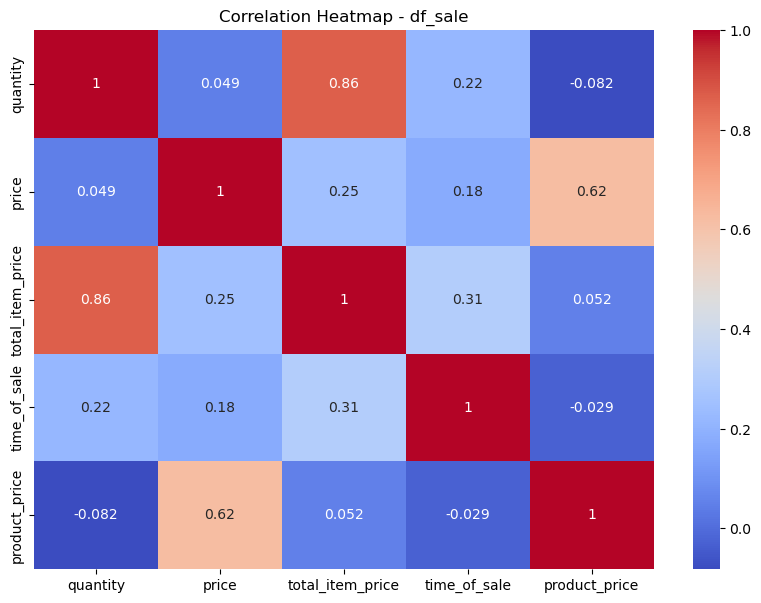

In [43]:
plt.figure(figsize=(10, 7))
sns.heatmap(df_sale.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - df_sale')
plt.show()

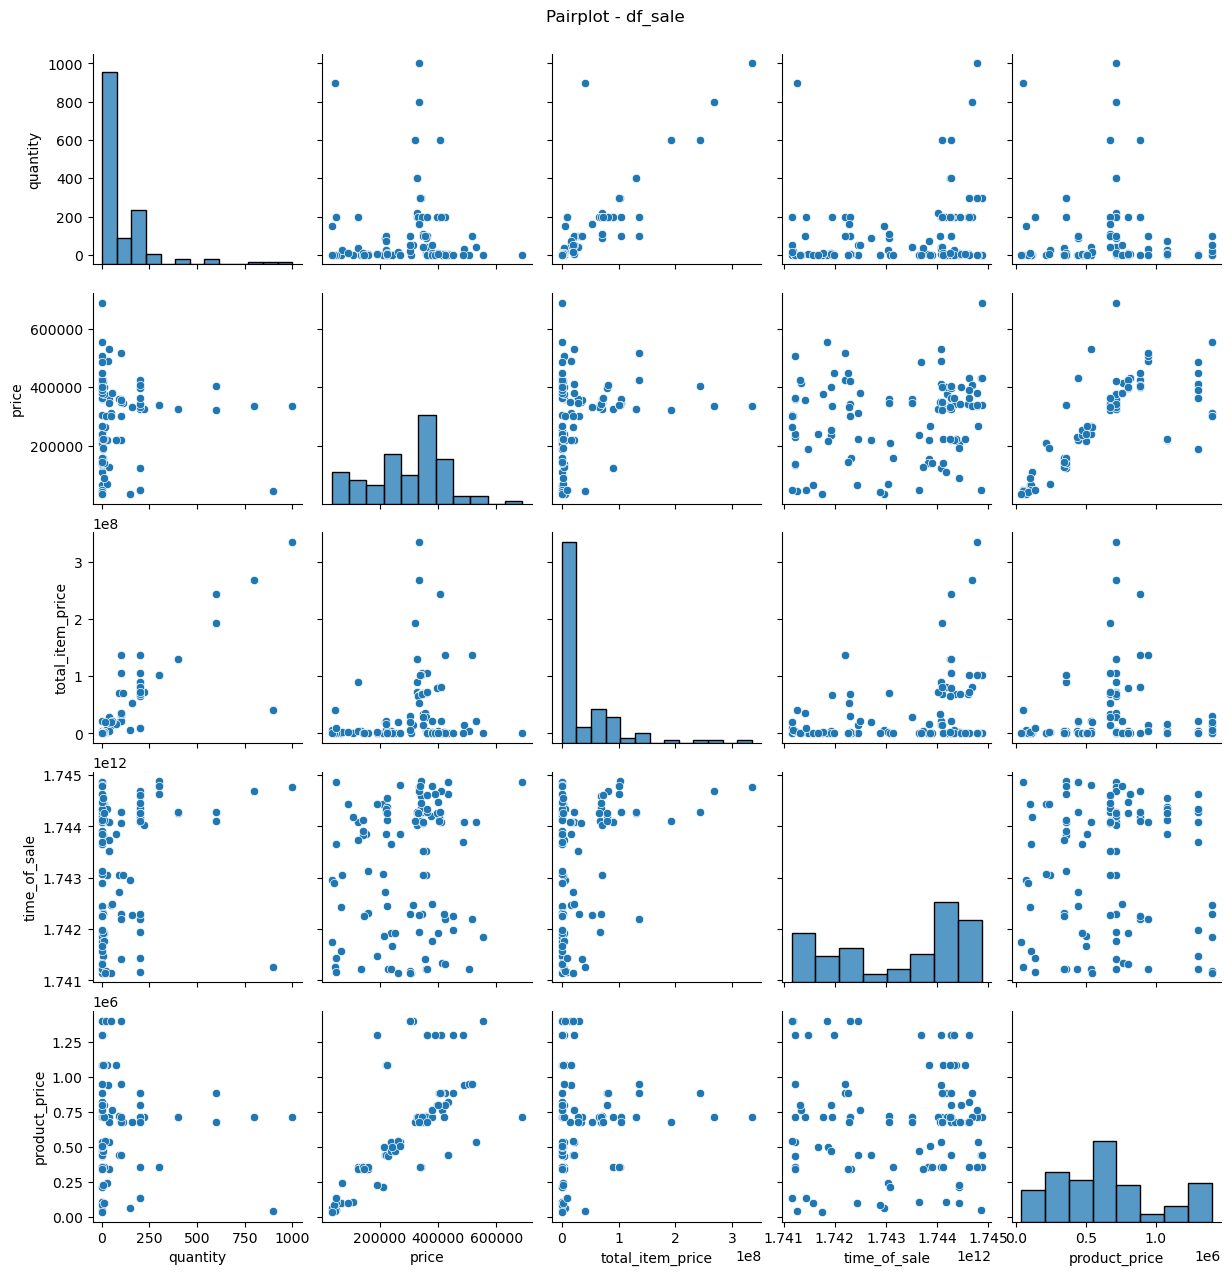

In [44]:
sns.pairplot(df_sale[['quantity', 'price', 'total_item_price', 'time_of_sale', 'product_price']])
plt.suptitle('Pairplot - df_sale', y=1.02)
plt.show()

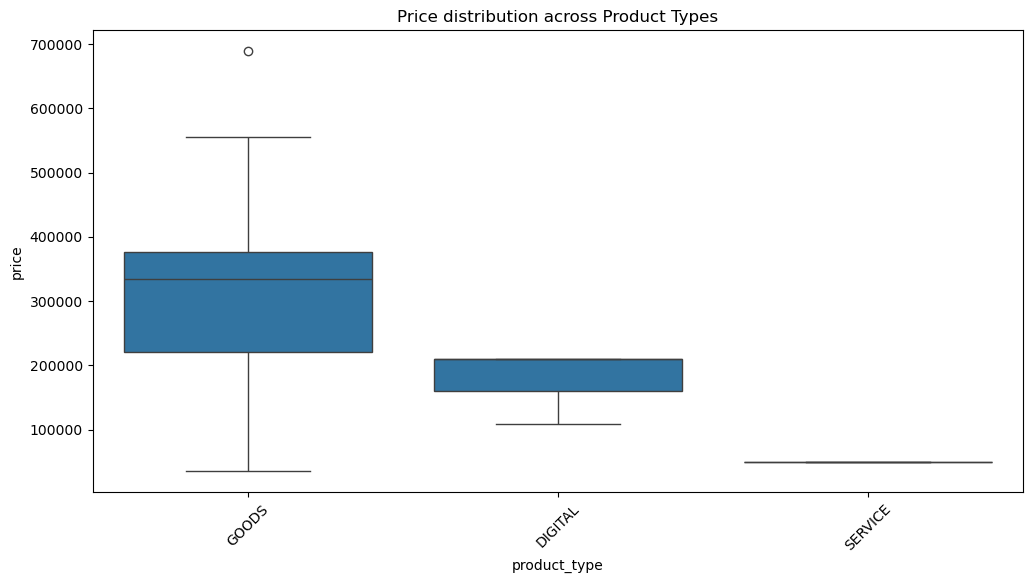

In [45]:
# 4. boxplot price vs product_type
plt.figure(figsize=(12,6))
sns.boxplot(x='product_type', y='price', data=df_sale)
plt.title('Price distribution across Product Types')
plt.xticks(rotation=45)
plt.show()

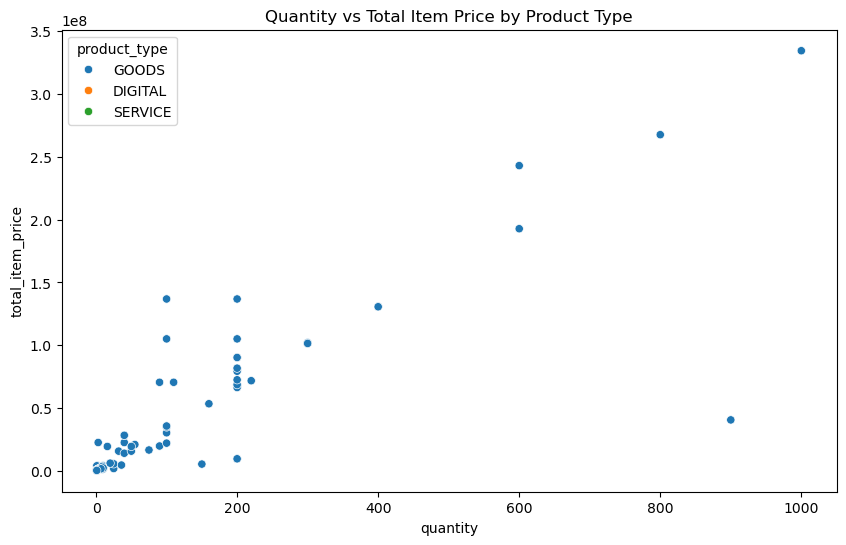

In [46]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_sale, x='quantity', y='total_item_price', hue='product_type')
plt.title('Quantity vs Total Item Price by Product Type')
plt.show()

#### 1.4.3.2 df_product

- Done by Nehaa Nayaana Amar Raj

In [47]:
# Prepare data: fill missing numeric for plotting (median fill)
df_farm_clean = df_farm.copy()
df_farm_clean['palm_trees_per_hectare'].fillna(df_farm_clean['palm_trees_per_hectare'].median(), inplace=True)
df_farm_clean['farm_latitude'].fillna(df_farm_clean['farm_latitude'].median(), inplace=True)
df_farm_clean['farm_longitude'].fillna(df_farm_clean['farm_longitude'].median(), inplace=True)
df_farm_clean['seed_type'].fillna('Unknown', inplace=True)

C:\Users\nehaa\AppData\Local\Temp\ipykernel_8900\2892358620.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_farm_clean['palm_trees_per_hectare'].fillna(df_farm_clean['palm_trees_per_hectare'].median(), inplace=True)
C:\Users\nehaa\AppData\Local\Temp\ipykernel_8900\2892358620.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on wh

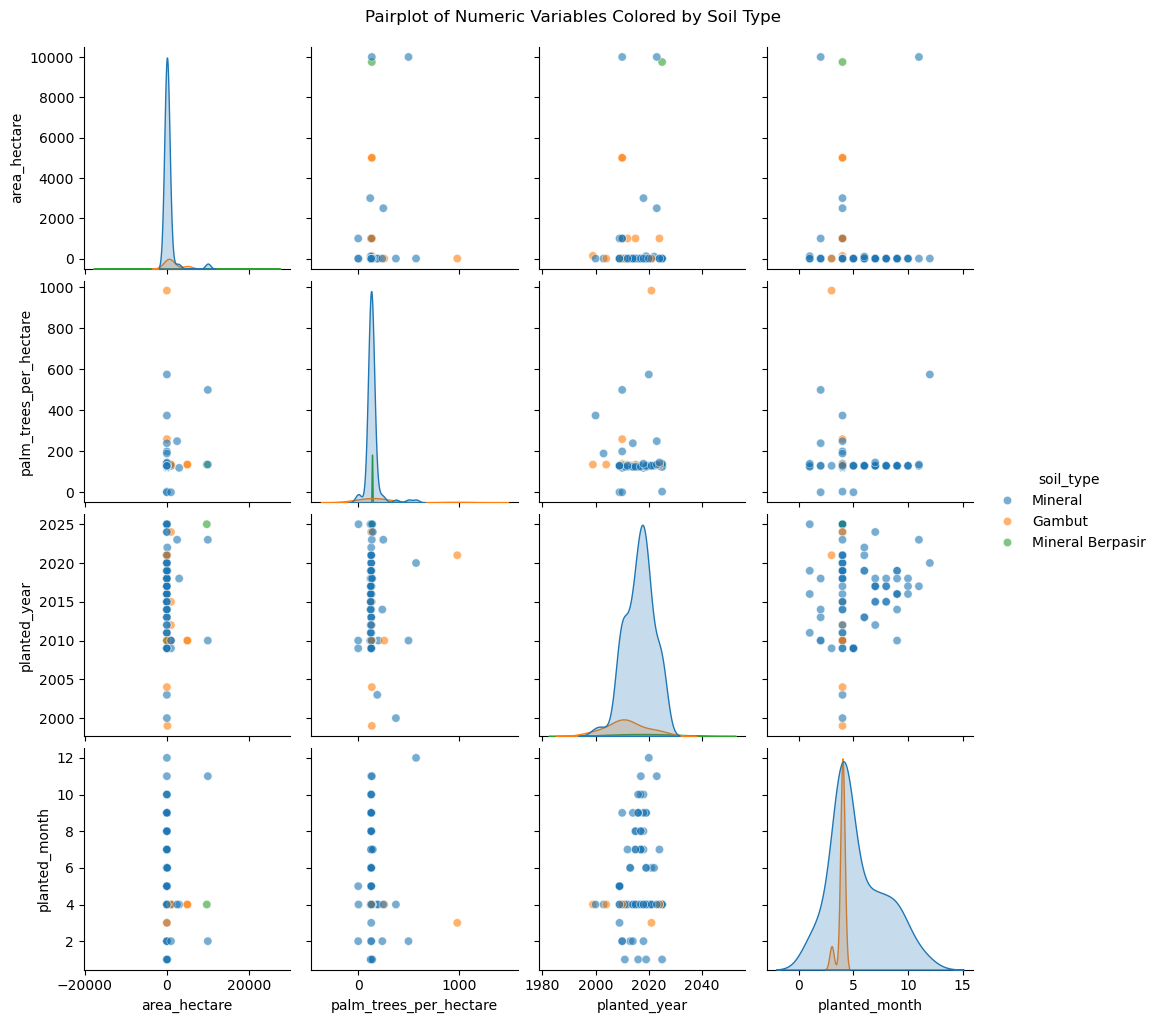

In [48]:
# pairplot for selected numeric columns colored by soil_type
sns.pairplot(df_farm_clean, 
             vars=['area_hectare', 'palm_trees_per_hectare', 'planted_year', 'planted_month'], 
             hue='soil_type', diag_kind='kde', plot_kws={'alpha':0.6})
plt.suptitle('Pairplot of Numeric Variables Colored by Soil Type', y=1.02)
plt.show()

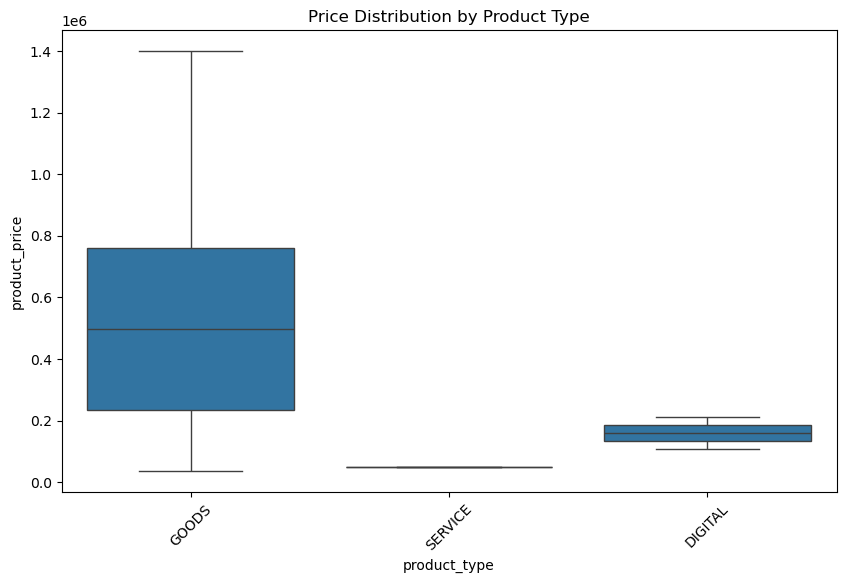

In [49]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_product, x='product_type', y='product_price')
plt.title('Price Distribution by Product Type')
plt.xticks(rotation=45)
plt.show()

# 2. Clean the Data

## 2.1 df_farm

- Done by Arienne Chin

### 2.1.1 Dropping unnecessary columns

- Done by Arienne Chin

In [50]:
df_farm = df_farm.drop(columns=['farm_latitude', 'farm_longitude'])

### 2.1.2 Handle missing values

- Done by Arienne Chin

In [51]:
# showing which columns have missing data
df_farm.isnull().mean().sort_values()

area_id                   0.00
planted_month             0.00
planted_year              0.00
area_hectare              0.00
owner_id                  0.00
farm_id                   0.00
subdistrict_longitude     0.00
soil_type                 0.00
subdistrict_latitude      0.00
district_longitude        0.00
district_latitude         0.00
district                  0.00
city                      0.00
province                  0.00
country                   0.00
area_name                 0.00
subdistrict               0.00
palm_trees_per_hectare    0.52
seed_type                 0.72
dtype: float64

In [52]:
# make a list with numerical variables (mean) and categorical variables (frequent). 

features_num_mean = ['palm_trees_per_hectare'] # list with numerical values

features_cat_frequent = ['seed_type'] # list with categorical values

In [53]:
# instantiate each imputer within a pipeline
pipe = Pipeline(steps=[ # defining pipeline
    ('imp_num_mean', mdi.MeanMedianImputer(imputation_method = 'mean', variables=features_num_mean)), # imputing numerical
    ('imp_cat_frequent', mdi.CategoricalImputer(variables = features_cat_frequent, imputation_method='frequent')) # imputing categorical
])

# fit the preprocessor
pipe.fit(df_farm)

Pipeline(steps=[('imp_num_mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['palm_trees_per_hectare'])),
                ('imp_cat_frequent',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['seed_type']))])

In [54]:
# impute the data
df_farm = pipe.transform(df_farm)

df_farm.isnull().sum() # show the final number of null values after imputation

area_id                   0
area_name                 0
country                   0
province                  0
city                      0
district                  0
district_latitude         0
district_longitude        0
subdistrict               0
subdistrict_latitude      0
subdistrict_longitude     0
farm_id                   0
owner_id                  0
area_hectare              0
planted_year              0
planted_month             0
palm_trees_per_hectare    0
soil_type                 0
seed_type                 0
dtype: int64

### 2.1.3 Handle outliers

- Done by Arienne Chin

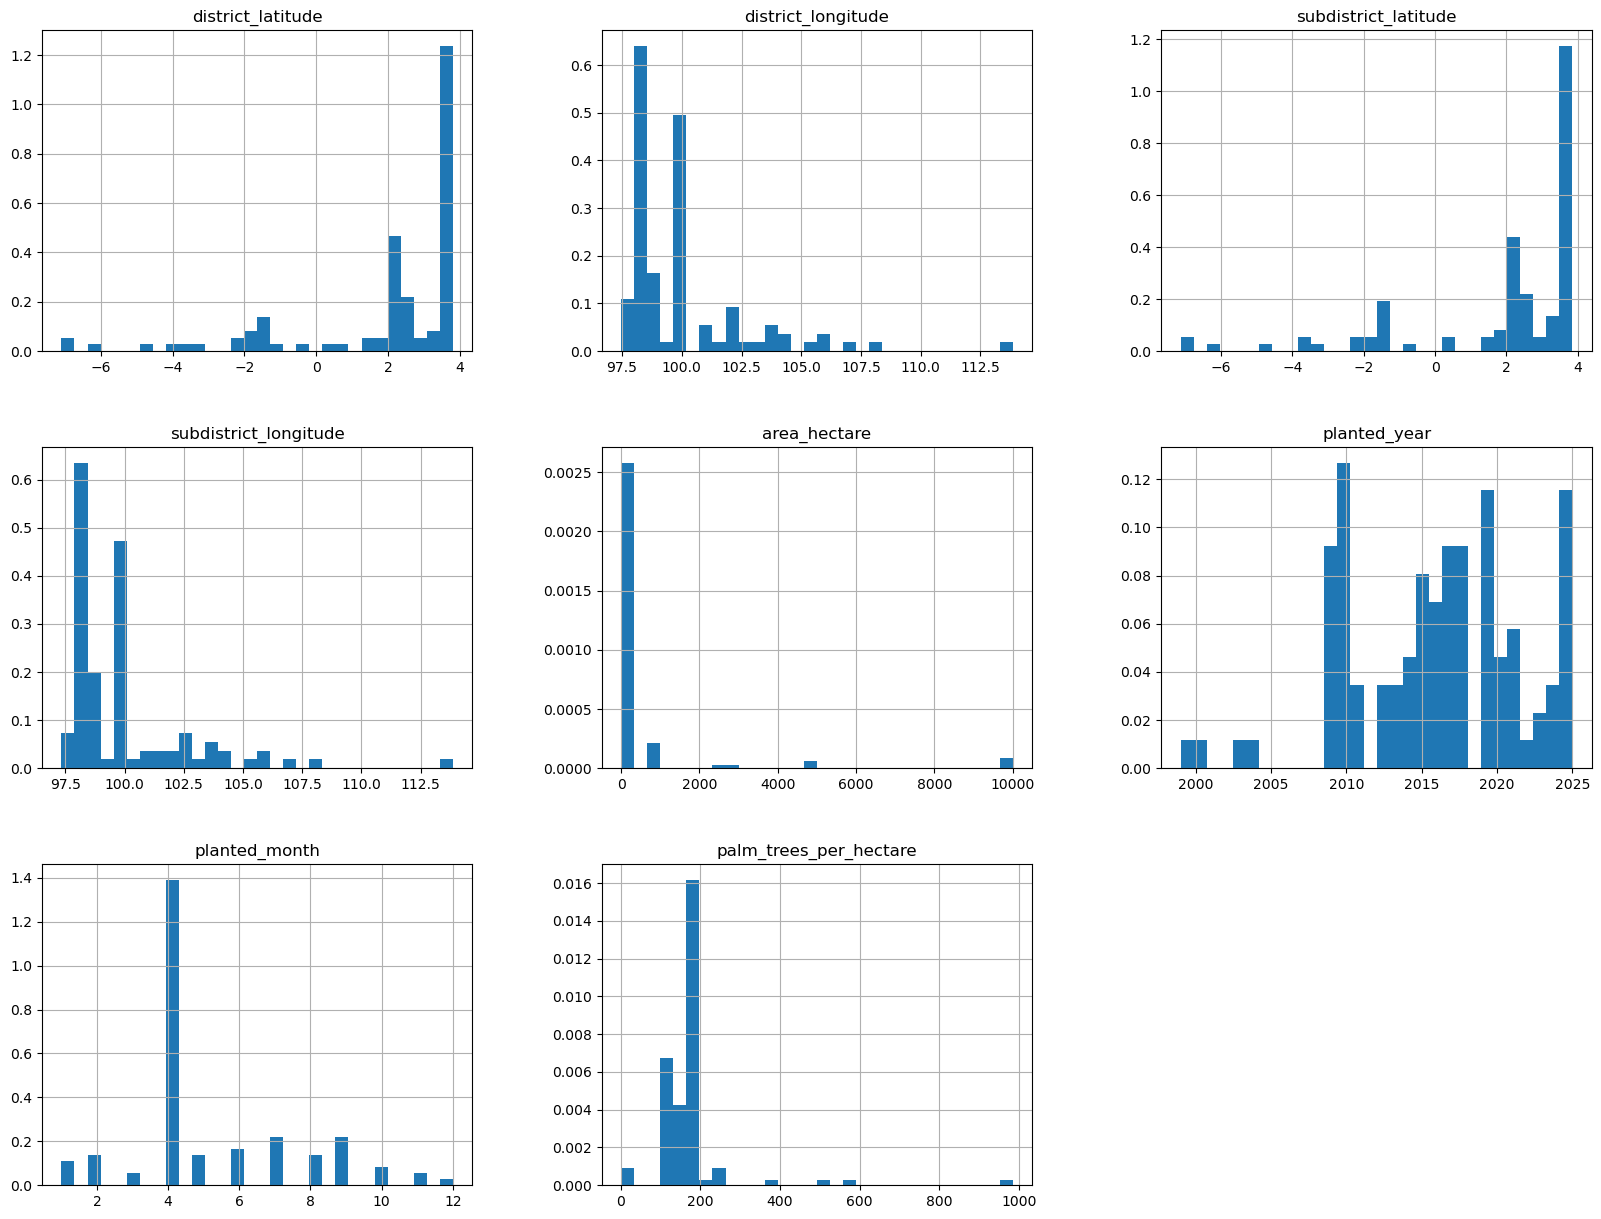

In [55]:
# showing the variable distribution in the df_farm in histograms
df_farm.hist(bins=30, figsize=(20, 15), density=True)
plt.show() # show the histogram

In [56]:
farm_num_cols = ['area_hectare', 'palm_trees_per_hectare'] # columns to work with for the outliers

print("Initial number of outliers:")

# Function to identify outliers using IQR method
def find_outliers_IQR(data): # define function
    outliers_indices = {} # adding a list so that it can be updated later on in the loop
    for col in data.select_dtypes(include=[np.number]).columns: # loop to find outliers in each column in num_cols
        Q1 = data[col].quantile(0.25) # finding the Q1
        Q3 = data[col].quantile(0.75) # finding the Q3
        IQR = Q3 - Q1 # finding the interquartile range
        lower_bound = Q1 - 1.5 * IQR # finding the lower boundary
        upper_bound = Q3 + 1.5 * IQR # finding the upper boundary
        outliers_indices[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)].index # finding the number of outliers
    return outliers_indices # return the final list

outliers_indices = find_outliers_IQR(df_farm[farm_num_cols]) # finding the number of values in the columns that are outliers

for col, indices in outliers_indices.items(): # print out the number of outliers for each column
    print(f'Outliers in {col}: {len(indices)}')

Initial number of outliers:
Outliers in area_hectare: 22
Outliers in palm_trees_per_hectare: 10


In [57]:
# Handle outliers (cap them at lower/upper bounds)
for col in farm_num_cols: # capping the outliers for all the columns specified earlier
    Q1 = df_farm[col].quantile(0.25) # finding the Q1
    Q3 = df_farm[col].quantile(0.75) # finding the Q3
    IQR = Q3 - Q1 # finding the interquartile range
    lower_bound = Q1 - 1.5 * IQR # finding the lower boundary
    upper_bound = Q3 + 1.5 * IQR # finding the upper boundary
    df_farm[col] = np.where(df_farm[col] < lower_bound, lower_bound, df_farm[col]) # dealing with the values that are less than Q1
    df_farm[col] = np.where(df_farm[col] > upper_bound, upper_bound, df_farm[col]) # dealing with the values that are more than Q3

In [58]:
print("\nFinal number of outliers after capping:")    

# Check that outliers have been handeled
for col in farm_num_cols:
    Q1 = df_farm[col].quantile(0.25) # finding the Q1
    Q3 = df_farm[col].quantile(0.75) # finding the Q3
    IQR = Q3 - Q1 # finding the interquartile range
    lower_bound = Q1 - 1.5 * IQR # finding the lower boundary
    upper_bound = Q3 + 1.5 * IQR # finding the upper boundary
    outliers = df_farm[(df_farm[col] < lower_bound) | (df_farm[col] > upper_bound)] # finding the number of outliers
    print(f'Outliers in {col}: {len(outliers)}') # printing the number of outliers left after capping


Final number of outliers after capping:
Outliers in area_hectare: 0
Outliers in palm_trees_per_hectare: 0


## 2.2 df_sale

- Done by Arienne Chin

### 2.2.1 Handle missing values

- Done by Arienne Chin

In [59]:
# showing which columns have missing data
df_sale.isnull().mean().sort_values()

farm_id                0.0
sale_order_id          0.0
product_id             0.0
quantity               0.0
price                  0.0
user_id                0.0
total_item_price       0.0
time_of_sale           0.0
product_sku            0.0
product_type           0.0
unit_of_measurement    0.0
product_name           0.0
product_price          0.0
product_description    0.0
sale_datetime          0.0
sale_date              0.0
dtype: float64

### 2.2.2 Handle outliers

- Done by Arienne Chin

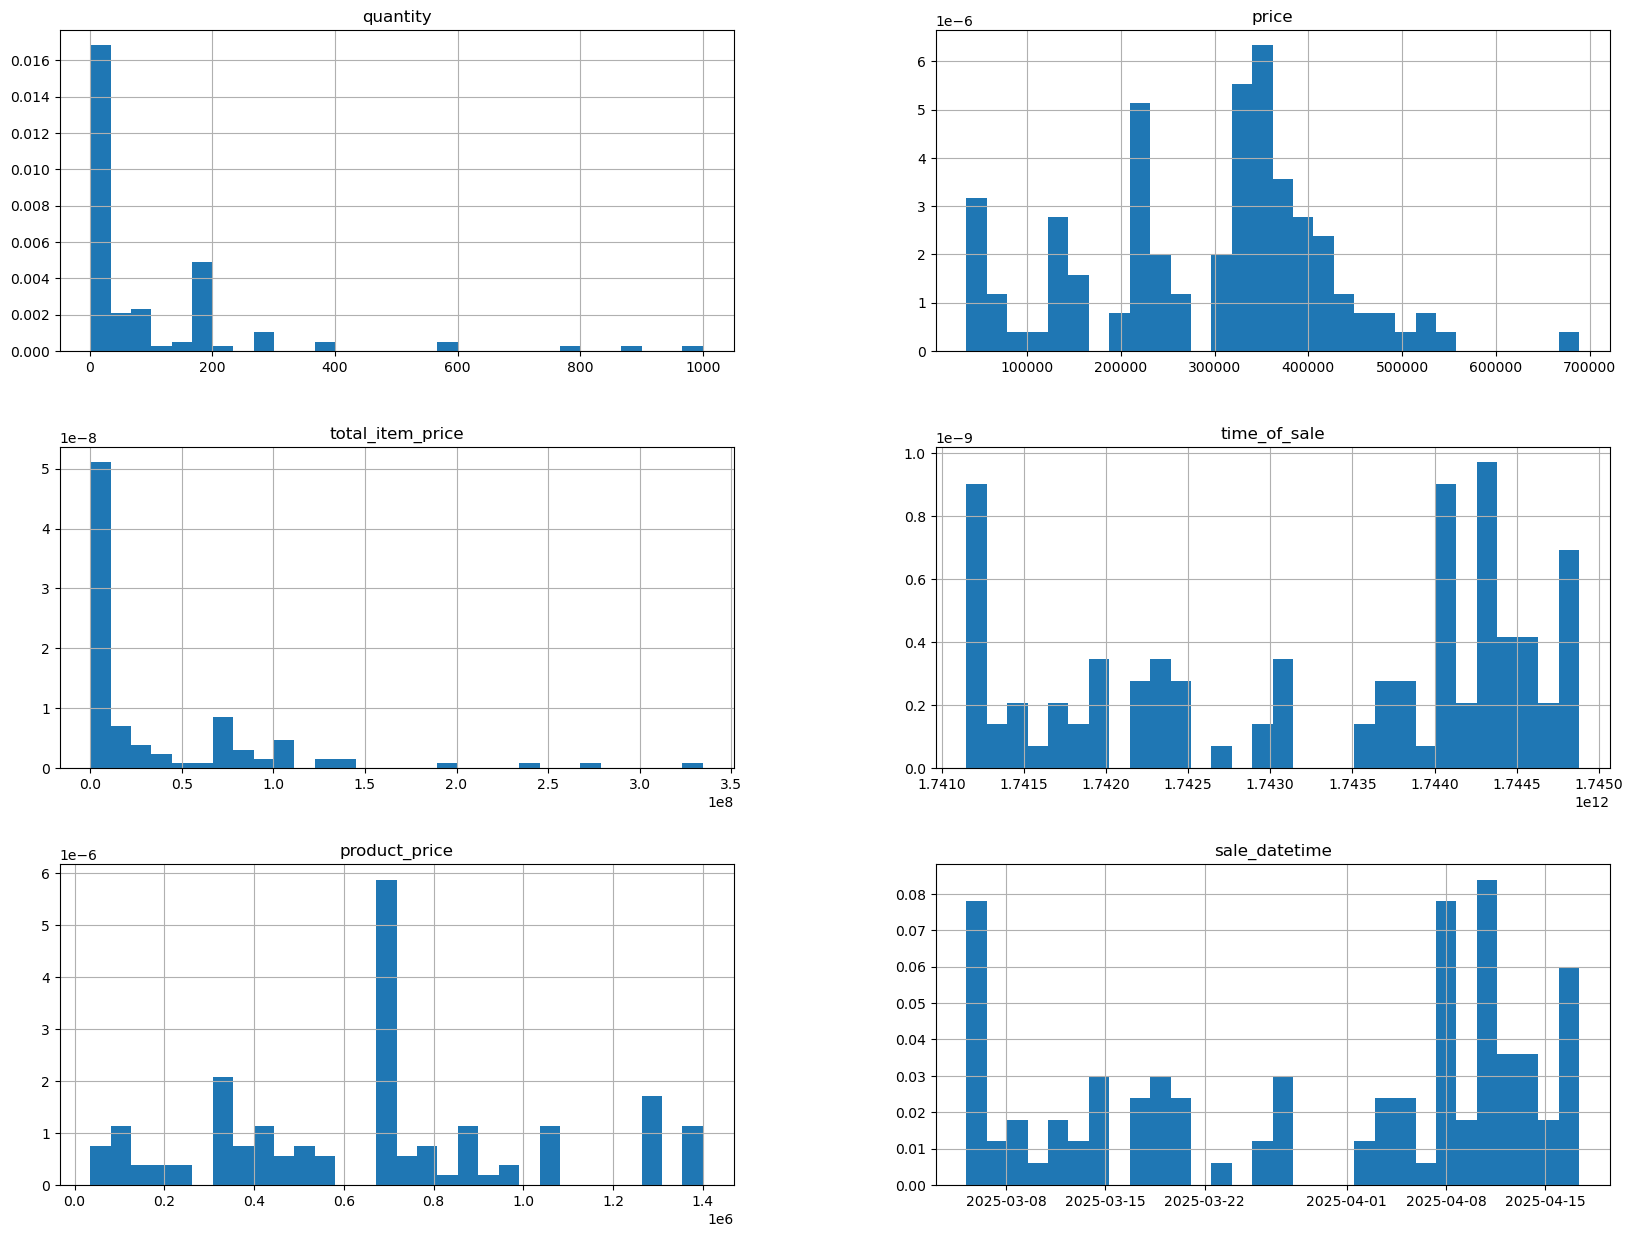

In [60]:
# showing the variable distribution in the df_farm in histograms
df_sale.hist(bins=30, figsize=(20, 15), density=True)
plt.show() # show the histogram

In [61]:
sale_num_cols = ['quantity', 'price', 'total_item_price'] # columns to work with for the outliers

print("Initial number of outliers:")

# Function to identify outliers using IQR method
def find_outliers_IQR(data): # define function
    outliers_indices = {} # adding a list so that it can be updated later on in the loop
    for col in data.select_dtypes(include=[np.number]).columns: # loop to find outliers in each column in num_cols
        Q1 = data[col].quantile(0.25) # finding the Q1
        Q3 = data[col].quantile(0.75) # finding the Q3
        IQR = Q3 - Q1 # finding the interquartile range
        lower_bound = Q1 - 1.5 * IQR # finding the lower boundary
        upper_bound = Q3 + 1.5 * IQR # finding the upper boundary
        outliers_indices[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)].index # finding the number of outliers
    return outliers_indices # return the final list

outliers_indices = find_outliers_IQR(df_sale[sale_num_cols]) # finding the number of values in the columns that are outliers

for col, indices in outliers_indices.items(): # print out the number of outliers for each column
    print(f'Outliers in {col}: {len(indices)}')

Initial number of outliers:
Outliers in quantity: 5
Outliers in price: 1
Outliers in total_item_price: 4


In [62]:
# Handle outliers (cap them at lower/upper bounds)
for col in sale_num_cols: # capping the outliers for all the columns specified earlier
    Q1 = df_sale[col].quantile(0.25) # finding the Q1
    Q3 = df_sale[col].quantile(0.75) # finding the Q3
    IQR = Q3 - Q1 # finding the interquartile range
    lower_bound = Q1 - 1.5 * IQR # finding the lower boundary
    upper_bound = Q3 + 1.5 * IQR # finding the upper boundary
    df_sale[col] = np.where(df_sale[col] < lower_bound, lower_bound, df_sale[col]) # dealing with the values that are less than Q1
    df_sale[col] = np.where(df_sale[col] > upper_bound, upper_bound, df_sale[col]) # dealing with the values that are more than Q3

In [63]:
print("\nFinal number of outliers after capping:")    

# Check that outliers have been handled
for col in sale_num_cols:
    Q1 = df_sale[col].quantile(0.25) # finding the Q1
    Q3 = df_sale[col].quantile(0.75) # finding the Q3
    IQR = Q3 - Q1 # finding the interquartile range
    lower_bound = Q1 - 1.5 * IQR # finding the lower boundary
    upper_bound = Q3 + 1.5 * IQR # finding the upper boundary
    outliers = df_farm[(df_sale[col] < lower_bound) | (df_sale[col] > upper_bound)] # finding the number of outliers
    print(f'Outliers in {col}: {len(outliers)}') # printing the number of outliers left after capping


Final number of outliers after capping:
Outliers in quantity: 0
Outliers in price: 0
Outliers in total_item_price: 0


C:\Users\nehaa\AppData\Local\Temp\ipykernel_8900\3788684400.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = df_farm[(df_sale[col] < lower_bound) | (df_sale[col] > upper_bound)] # finding the number of outliers
C:\Users\nehaa\AppData\Local\Temp\ipykernel_8900\3788684400.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = df_farm[(df_sale[col] < lower_bound) | (df_sale[col] > upper_bound)] # finding the number of outliers
C:\Users\nehaa\AppData\Local\Temp\ipykernel_8900\3788684400.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = df_farm[(df_sale[col] < lower_bound) | (df_sale[col] > upper_bound)] # finding the number of outliers


### 2.2.3 Translate the product description

- Done by Nehaa Nayaana Amar Raj

In [64]:
# !pip install beautifulsoup4 googletrans==4.0.0-rc1

In [65]:
from bs4 import BeautifulSoup
from googletrans import Translator
import re
import pandas as pd

# Sample setup: assuming df_sale is already loaded
# df_sale = pd.read_csv('your_file.csv')

translator = Translator()

def clean_html(text):
    """Remove HTML tags and convert to plain text."""
    return BeautifulSoup(text, "html.parser").get_text(separator=" ") if pd.notnull(text) else ""

def normalize_whitespace(text):
    """Remove extra whitespace and newlines."""
    return re.sub(r'\s+', ' ', text).strip()

def translate_to_english(text):
    """Translate Indonesian text to English."""
    try:
        translated = translator.translate(text, src='id', dest='en')
        return translated.text
    except Exception as e:
        return text  # Fallback: return original if translation fails

def clean_and_translate(text):
    """Combined function to clean and translate."""
    no_html = clean_html(text)
    normalized = normalize_whitespace(no_html)
    translated = translate_to_english(normalized)
    return translated

# Apply to the 'product_description' column
df_sale['product_description_en'] = df_sale['product_description'].apply(clean_and_translate)

# Preview result
print(df_sale[['product_description', 'product_description_en']].head())

# Apply to the 'product_description' column
df_sale['product_name_en'] = df_sale['product_name'].apply(clean_and_translate)

# Preview result
print(df_sale[['product_name', 'product_name_en']].head())



                                 product_description  \
0  Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...   
1  Rock Phosphate (RP) adalah salah satu sumber f...   
2                Topup PLN 100.000 Topup PLN 100.000   
3  <p>Kaos tidak berkerah warna Putih bertuliskan...   
4  Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...   

                              product_description_en  
0  MOP/KCL fertilizer to improve the quality and ...  
1  Rock Phosphate (RP) is one of the best sources...  
2                Topup PLN 100,000 Topup PLN 100,000  
3  The white collared shirt that reads "Sibrondol...  
4  MOP/KCL fertilizer to improve the quality and ...  


C:\Users\nehaa\AppData\Local\Temp\ipykernel_8900\1748948745.py:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text(separator=" ") if pd.notnull(text) else ""


                      product_name                      product_name_en
0  MOP/KCL Canada Cap Mahkota 50kg      MOP/KCL Canada Cap Mahkota 50kg
1          RP Mahkota 50kg - Egypt               Rp. 50kg crown - Egypt
2                Token PLN 100.000                    Token PLN 100,000
3  Kaos SIBRONDOL SawitPRO size XL  T -shirt Sibrondol Sawitpro Size XL
4  MOP/KCL Canada Cap Mahkota 50kg      MOP/KCL Canada Cap Mahkota 50kg


In [66]:
# df_sale = df_sale.drop("product_description")
# df_sale = df_sale.drop("product_name")


In [67]:
df_sale.head()

,farm_id,sale_order_id,product_id,quantity,price,user_id,total_item_price,time_of_sale,product_sku,product_type,unit_of_measurement,product_name,product_price,product_description,sale_datetime,sale_date,product_description_en,product_name_en
0,d4dc9c06-177e-494c-ba72-7e2954ce8ced,3ddca641-cb59-4a27-8698-cb16ff2932f2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,200.0,326000.000,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...,2025-04-08 02:19:58.583,2025-04-08,MOP/KCL fertilizer to improve the quality and ...,MOP/KCL Canada Cap Mahkota 50kg
1,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200.0,125000.000,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,Rock Phosphate (RP) adalah salah satu sumber f...,2025-04-08 02:19:58.583,2025-04-08,Rock Phosphate (RP) is one of the best sources...,Rp. 50kg crown - Egypt
2,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1.0,109000.000,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000,2025-04-09 07:03:22.966,2025-04-09,"Topup PLN 100,000 Topup PLN 100,000","Token PLN 100,000"
3,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1.0,65000.000,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,<p>Kaos tidak berkerah warna Putih bertuliskan...,2025-03-20 02:45:12.361,2025-03-20,"The white collared shirt that reads ""Sibrondol...",T -shirt Sibrondol Sawitpro Size XL
4,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2.0,588484.375,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...,2025-04-17 07:23:18.061,2025-04-17,MOP/KCL fertilizer to improve the quality and ...,MOP/KCL Canada Cap Mahkota 50kg


### 2.2.4 Feature Extraction from Product Descriptions

- Done by Nehaa Nayaana Amar Raj

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

Item to item based recommendation system based on product description

In [69]:
# Converting the text in product description into numerical data for analysis
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(df_sale["product_description_en"])
X1

<116x692 sparse matrix of type '<class 'numpy.float64'>'
	with 7214 stored elements in Compressed Sparse Row format>

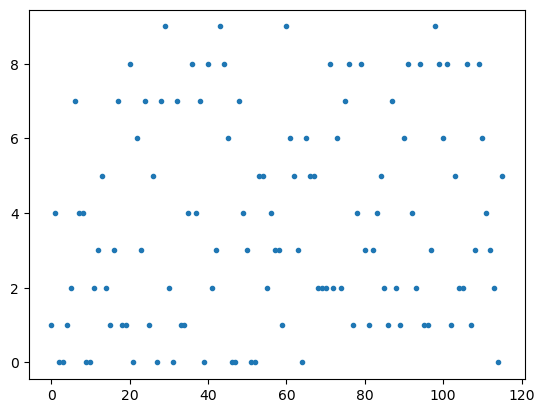

In [70]:
# Fitting K-Means to the dataset

X=X1

kmeans = KMeans(n_clusters = 10, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()

In [71]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [72]:
# # Optimal clusters is 

true_k = 10

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print_cluster(i)


Top terms per cluster:
Cluster 0:
 powder
 processed
 phosphate
 stems
 rp
 plants
 phosphorus
 roots
 fertilizer
 improve
Cluster 1:
 potassium
 kcl
 fertilizer
 plants
 mop
 60
 k2o
 require
 use
 quality
Cluster 2:
 sp
 organic
 sawitpro
 fertilizer
 nitrogen
 microorganisms
 decomposition
 janjang
 growth
 potassium
Cluster 3:
 46
 urea
 nitrea
 nitrogen
 fertilizer
 50kg
 granules
 forage
 retail
 prill
Cluster 4:
 weeds
 leaf
 solution
 sl
 wide
 tbm
 490
 herbicide
 narrow
 green
Cluster 5:
 magnesium
 27
 13
 fertilizer
 oxide
 boron
 growth
 plant
 sulfate
 phosphorus
Cluster 6:
 000
 topup
 pln
 200
 100
 durability
 efficiency
 effectiveness
 effectively
 effective
Cluster 7:
 boron
 small
 essential
 plants
 physical
 borat
 borate
 usually
 fertilizing
 micronutrient
Cluster 8:
 dolomite
 100
 tsp
 super
 gray
 fertilizer
 soil
 phosphorus
 inti
 mg
Cluster 9:
 sulfur
 zinc
 15
 increase
 size
 number
 plant
 za
 growth
 24


In [73]:
# Predicting clusters based on key search words
def show_recommendations(product):
    #print("Cluster ID:")
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    #print(prediction)
    print_cluster(prediction[0])

In [74]:
# keyword: effective
show_recommendations("effective")

Cluster 4:
 weeds
 leaf
 solution
 sl
 wide
 tbm
 490
 herbicide
 narrow
 green


In case a word appears in multiple clusters, the algorithm chooses the cluster with the highest frequency of occurance of the word.

Output

- 
Recommendation of product based on the current product selected by user.- 
To recommend related product based on, Frequently bought together.

# 3. Build a User-Product Interaction Matrix (Recommendation Model)

## 3.1 Model 1 (By Arienne)

- Done by Arienne Chin

### 3.1.1 Building Model 1

- Done by Arienne Chin

In [75]:
# making the user-product interaction matrix
user_product_matrix = df_sale.pivot_table(
    index='user_id',
    columns='product_id',
    values='quantity',   # or 'total_item_price' if you prefer
    aggfunc='sum',
    fill_value=0
)

In [76]:
# Transpose the matrix to get product-user
product_user_matrix = user_product_matrix.T

# Compute item-item similarity
item_similarity = cosine_similarity(product_user_matrix)

# Turn into DataFrame
item_similarity_df = pd.DataFrame(item_similarity,
                                  index=product_user_matrix.index,
                                  columns=product_user_matrix.index)

#### 3.1.1.1 Based on products

- Done by Arienne Chin

In [77]:
def recommend_similar_products1(product_name, top_n=10):
    if product_name not in item_similarity_df:
        return f"{product_name} not found in product list."
    similar_scores = item_similarity_df[product_name].sort_values(ascending=False)
    return similar_scores.iloc[1:top_n+1]  # Skip the first one (it's the product itself)

# Example usage (key in product_id)
recommend_similar_products1('80957603-6cec-4f63-8dcd-aba6ded5cbdd')

# What it does:
# Takes a product_id and finds the top 5 most similar products based on cosine similarity scores.
# It skips the first one (because a product is always 100% similar to itself).
# Example use case: “If a user likes Product A, what else might they like?”
# If the product has no users in common with others → similarity = 0.

product_id
ece9fda2-1006-4cf9-a283-74e10b330512    0.821204
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.285172
4cac8d01-b78e-4017-9113-c627ac1866a5    0.196691
e8898291-543b-439c-907f-bd80075f02a0    0.171112
b53ce31c-3789-42d7-96a0-5fe058cac7a5    0.142332
a48adaed-ab06-4245-8da6-5d560636a1d9    0.133463
369cfbc5-f536-41f5-8a80-267d55dec802    0.002139
1af0394e-3aea-42b4-8698-b6832e35f8ce    0.001913
ecef7b49-b297-4c53-bf53-628861221da7    0.000512
c2b3d62f-6c48-4051-beb1-3ec66d30c1da    0.000117
Name: 80957603-6cec-4f63-8dcd-aba6ded5cbdd, dtype: float64

#### 3.1.1.2 Based on user

- Done by Arienne Chin

In [78]:
def recommend_for_user1(user_id, top_n=10):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."

    user_purchases = user_product_matrix.loc[user_id]
    purchased = user_purchases[user_purchases > 0].index.tolist()

    scores = pd.Series(dtype='float64')

    for product in purchased:
        similar_products = item_similarity_df[product].drop(purchased)
        scores = scores.add(similar_products, fill_value=0)

    return scores.sort_values(ascending=False).head(top_n)

# key in user_id
recommend_for_user1('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

# What it does:
# Takes a user ID, finds the products they’ve already bought, and then:
# Looks up products similar to those they’ve bought.
# Combines all the scores of those similar products (ignores products already purchased).
# Recommends the top 5 highest scoring ones.

product_id
ece9fda2-1006-4cf9-a283-74e10b330512    0.821204
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.285372
4cac8d01-b78e-4017-9113-c627ac1866a5    0.196691
e8898291-543b-439c-907f-bd80075f02a0    0.171112
a48adaed-ab06-4245-8da6-5d560636a1d9    0.136040
369cfbc5-f536-41f5-8a80-267d55dec802    0.012119
1af0394e-3aea-42b4-8698-b6832e35f8ce    0.010840
c2b3d62f-6c48-4051-beb1-3ec66d30c1da    0.000662
ecef7b49-b297-4c53-bf53-628861221da7    0.000512
6c27fc9c-e7e9-4e9b-9017-292175250df1    0.000032
dtype: float64

### 3.1.2 Evaluation of Model 1

- Done by Arienne Chin

#### 3.2.1.1 Content-based Filtering

- Done by Arienne Chin

In [79]:
# Accuracy at k
def accuracy_at_k(user_id, k=5):
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    recommended_products = []

    for product in actual_purchases:
        similar = recommend_similar_products1(product, top_n=k)
        if isinstance(similar, pd.Series):
            recommended_products.extend(similar.index.tolist())

    recommended_products = list(set(recommended_products))
    if not actual_purchases or not recommended_products:
        return 0
    return 1 if len(set(recommended_products) & set(actual_purchases)) > 0 else 0

In [80]:
# Evaluate for all users
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=5) for user_id in user_ids]

In [81]:
# Average accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.1918


#### 3.2.1.2 Collaborative Filtering

- Done by Arienne Chin

In [82]:
# calculate accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = recommend_for_user1(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    # If any recommended product was actually purchased, it's a "hit"
    if not actual_purchases:
        return 0
    return 1 if len(set(recommended_products) & set(actual_purchases)) > 0 else 0

In [83]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Average Accuracy: {avg_accuracy:.4f}")

Average Accuracy: 0.1918


## 3.2 Model 2

- Done by Arienne Chin

### 3.2.1 Building Model 2 (Hybrid Recommendation System)

- Done by Arienne Chin

In [84]:
# using more informative weights
user_product_matrix = df_sale.pivot_table(
    index='user_id',
    columns='product_id',
    values='total_item_price',
    aggfunc='sum',
    fill_value=0
)

In [85]:
# normalize interaction matrix
normalized_matrix = normalize(user_product_matrix)
user_product_matrix = pd.DataFrame(normalized_matrix, 
                                   index=user_product_matrix.index, 
                                   columns=user_product_matrix.columns)

In [86]:
# filter infrequent products
product_counts = (user_product_matrix > 0).sum()
frequent_products = product_counts[product_counts >= 3].index
user_product_matrix = user_product_matrix[frequent_products]

In [87]:
# user based model
user_similarity = cosine_similarity(user_product_matrix)
user_similarity_df = pd.DataFrame(user_similarity, 
                                  index=user_product_matrix.index, 
                                  columns=user_product_matrix.index)

In [88]:
# build the hybrid model
def hybrid_recommend2(user_id, top_n=5, alpha=0.5):
    # Item-based
    item_scores = recommend_for_user1(user_id, top_n=top_n * 2)

    # User-based (get top similar users)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(item_scores.index, errors='ignore')

    # Combine scores
    combined = alpha * item_scores.add((1 - alpha) * user_based_scores, fill_value=0)
    return combined.sort_values(ascending=False).head(top_n)

# key in user_id
hybrid_recommend2('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
80957603-6cec-4f63-8dcd-aba6ded5cbdd    1.094491
ece9fda2-1006-4cf9-a283-74e10b330512    0.410602
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.142686
4cac8d01-b78e-4017-9113-c627ac1866a5    0.098346
b53ce31c-3789-42d7-96a0-5fe058cac7a5    0.094491
dtype: float64

### 3.2.2 Evaluation of Model 2

- Done by Arienne Chin

In [89]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend2(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [90]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [91]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.7260


## 3.3 Model 3

- Done by Arienne Chin

### 3.3.1 Building Model 3 (with weighted blending)

- Done by Arienne Chin

In [92]:
def hybrid_recommend3(user_id, top_n=5, alpha=0.5):
    if user_id not in user_product_matrix.index:
        return pd.Series(dtype='float64')
    
    # Item-based scores
    item_scores = recommend_for_user1(user_id, top_n=top_n * 2)

    # User-based: get scores from similar users
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum()

    # Combine using weighted blending
    combined_scores = alpha * item_scores.add((1 - alpha) * user_based_scores, fill_value=0)

    # Remove items the user already purchased
    purchased = user_product_matrix.loc[user_id]
    purchased_items = purchased[purchased > 0].index
    combined_scores = combined_scores.drop(purchased_items, errors='ignore')

    return combined_scores.sort_values(ascending=False).head(top_n)

In [93]:
# key in user_id
hybrid_recommend3('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
ece9fda2-1006-4cf9-a283-74e10b330512    0.410602
a48adaed-ab06-4245-8da6-5d560636a1d9    0.162511
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.142686
4cac8d01-b78e-4017-9113-c627ac1866a5    0.098346
c2b3d62f-6c48-4051-beb1-3ec66d30c1da    0.094822
dtype: float64

### 3.3.2 Evaluation of Model 3

- Done by Arienne Chin

In [94]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend3(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [95]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [96]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.0000


## 3.4 Model 4

- Done by Arienne Chin

### 3.4.1 Build Model 4 (normalise scores before blending)

- Done by Arienne Chin

In [97]:
def hybrid_recommend4(user_id, top_n=5, alpha=0.5):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = alpha * combined_df['collab'] + (1 - alpha) * combined_df['user']
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [98]:
# key in user_id
hybrid_recommend4('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
ece9fda2-1006-4cf9-a283-74e10b330512    0.500000
80957603-6cec-4f63-8dcd-aba6ded5cbdd    0.500000
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.173752
4cac8d01-b78e-4017-9113-c627ac1866a5    0.119758
e8898291-543b-439c-907f-bd80075f02a0    0.104183
Name: score, dtype: float64

### 3.4.2 Evaluation of Model 4

- Done by Arienne Chin

In [99]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend4(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [100]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [101]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.7260


## 3.5 Model 5

- Done by Arienne Chin

### 3.5.1 Building Model 5 (adjusting alpha weight)

- Done by Arienne Chin

In [102]:
def hybrid_recommend5(user_id, top_n=5, alpha=0.8):
    if user_id not in user_product_matrix.index:
        return pd.Series(dtype='float64')
    
    # Item-based scores
    item_scores = recommend_for_user1(user_id, top_n=top_n * 2)  # More candidates

    # User-based scores
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(item_scores.index, errors='ignore')

    # Weighted blend (no normalization)
    combined_scores = alpha * item_scores.add((1 - alpha) * user_based_scores, fill_value=0)

    return combined_scores.sort_values(ascending=False).head(top_n)

In [103]:
# key in user_id
hybrid_recommend5('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
80957603-6cec-4f63-8dcd-aba6ded5cbdd    0.700474
ece9fda2-1006-4cf9-a283-74e10b330512    0.656963
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.228297
4cac8d01-b78e-4017-9113-c627ac1866a5    0.157353
e8898291-543b-439c-907f-bd80075f02a0    0.136889
dtype: float64

### 3.5.2 Evaluation of Model 5

- Done by Arienne Chin

In [104]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend5(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [105]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [106]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.7123


## 3.6 Model 6 (Testing with different top_n values)

- Done by Arienne Chin

### 3.6.1 top_n = 5

- Done by Arienne Chin

In [107]:
def hybrid_recommend4(user_id, top_n=5, alpha=0.5):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = alpha * combined_df['collab'] + (1 - alpha) * combined_df['user']
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [108]:
# key in user_id
# to show how strongly the model recommends the products to the user
hybrid_recommend4('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
ece9fda2-1006-4cf9-a283-74e10b330512    0.500000
80957603-6cec-4f63-8dcd-aba6ded5cbdd    0.500000
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.173752
4cac8d01-b78e-4017-9113-c627ac1866a5    0.119758
e8898291-543b-439c-907f-bd80075f02a0    0.104183
Name: score, dtype: float64

In [109]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend4(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [110]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [111]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.7260


### 3.6.2 top_n = 10

- Done by Arienne Chin

In [112]:
def hybrid_recommend6(user_id, top_n=10, alpha=0.5):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = alpha * combined_df['collab'] + (1 - alpha) * combined_df['user']
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [113]:
# key in user_id
hybrid_recommend6('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
ece9fda2-1006-4cf9-a283-74e10b330512    0.500000
80957603-6cec-4f63-8dcd-aba6ded5cbdd    0.500000
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.173752
4cac8d01-b78e-4017-9113-c627ac1866a5    0.119758
e8898291-543b-439c-907f-bd80075f02a0    0.104183
a48adaed-ab06-4245-8da6-5d560636a1d9    0.082830
b53ce31c-3789-42d7-96a0-5fe058cac7a5    0.043167
369cfbc5-f536-41f5-8a80-267d55dec802    0.007379
1af0394e-3aea-42b4-8698-b6832e35f8ce    0.006600
c2b3d62f-6c48-4051-beb1-3ec66d30c1da    0.000403
Name: score, dtype: float64

In [114]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend6(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [115]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [116]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.7260


### 3.6.3 top_n = 20

- Done by Arienne Chin

In [117]:
def hybrid_recommend7(user_id, top_n=20, alpha=0.5):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = alpha * combined_df['collab'] + (1 - alpha) * combined_df['user']
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [118]:
# key in user_id
hybrid_recommend7('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
ece9fda2-1006-4cf9-a283-74e10b330512    0.500000
80957603-6cec-4f63-8dcd-aba6ded5cbdd    0.500000
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.173752
4cac8d01-b78e-4017-9113-c627ac1866a5    0.119758
e8898291-543b-439c-907f-bd80075f02a0    0.104183
a48adaed-ab06-4245-8da6-5d560636a1d9    0.082830
b53ce31c-3789-42d7-96a0-5fe058cac7a5    0.043167
369cfbc5-f536-41f5-8a80-267d55dec802    0.007379
1af0394e-3aea-42b4-8698-b6832e35f8ce    0.006600
c2b3d62f-6c48-4051-beb1-3ec66d30c1da    0.000403
ecef7b49-b297-4c53-bf53-628861221da7    0.000312
6c27fc9c-e7e9-4e9b-9017-292175250df1    0.000019
ff58b8c4-1058-4753-bfc0-c04d091c8485    0.000000
2485b082-5258-44c1-b6aa-983387d540a7    0.000000
2b8fe2f0-5d07-459c-8781-22305a61980a    0.000000
4698d965-a133-4701-838b-f60e38c66b39    0.000000
487f2886-5150-4269-94e2-63fbc7314971    0.000000
89f26d03-4933-4924-ae31-5eef6981122f    0.000000
5501ce77-7a08-4086-8dda-858c92326fc6    0.000000
5952d124-7dc6-4a6a-baa2-e2e502ecd6fe    0.000000
Name: sco

In [119]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend7(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [120]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [121]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.7260


## 3.6.4 Comparing the models based on the different top_n values

- Done by Arienne Chin

## 3.7 Model 7 (Testing with different alpha ranges)

- Done by Arienne Chin

### 3.7.1 alpha range = 0.0 (only user based)

- Done by Arienne Chin

In [122]:
def hybrid_recommend0(user_id, top_n=5, alpha=0.0):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = alpha * combined_df['collab'] + (1 - alpha) * combined_df['user']
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [123]:
# key in user_id
hybrid_recommend0('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
80957603-6cec-4f63-8dcd-aba6ded5cbdd    1.000000
b53ce31c-3789-42d7-96a0-5fe058cac7a5    0.086333
ece9fda2-1006-4cf9-a283-74e10b330512    0.000000
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.000000
4cac8d01-b78e-4017-9113-c627ac1866a5    0.000000
Name: score, dtype: float64

In [124]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend0(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [125]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [126]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.7260


### 3.7.2 alpha range = 0.3 (30% collab, 70% user)

- Done by Arienne Chin

In [127]:
def hybrid_recommend8(user_id, top_n=5, alpha=0.3):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = alpha * combined_df['collab'] + (1 - alpha) * combined_df['user']
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [128]:
# key in user_id
hybrid_recommend8('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
80957603-6cec-4f63-8dcd-aba6ded5cbdd    0.700000
ece9fda2-1006-4cf9-a283-74e10b330512    0.300000
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.104251
4cac8d01-b78e-4017-9113-c627ac1866a5    0.071855
e8898291-543b-439c-907f-bd80075f02a0    0.062510
Name: score, dtype: float64

In [129]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend8(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [130]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [131]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.7260


### 3.7.3 alpha range = 0.5 (50% collab, 50% user)

- Done by Arienne Chin

In [132]:
# this is the base model

In [133]:
def hybrid_recommend4(user_id, top_n=5, alpha=0.5):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = alpha * combined_df['collab'] + (1 - alpha) * combined_df['user']
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [134]:
# key in user_id
hybrid_recommend4('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
ece9fda2-1006-4cf9-a283-74e10b330512    0.500000
80957603-6cec-4f63-8dcd-aba6ded5cbdd    0.500000
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.173752
4cac8d01-b78e-4017-9113-c627ac1866a5    0.119758
e8898291-543b-439c-907f-bd80075f02a0    0.104183
Name: score, dtype: float64

In [135]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend4(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [136]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [137]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.7260


### 3.7.4 alpha range = 0.7 (70% collab, 30% user)

- Done by Arienne Chin

In [138]:
def hybrid_recommend10(user_id, top_n=5, alpha=0.7):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = alpha * combined_df['collab'] + (1 - alpha) * combined_df['user']
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [139]:
# key in user_id
hybrid_recommend10('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
ece9fda2-1006-4cf9-a283-74e10b330512    0.700000
80957603-6cec-4f63-8dcd-aba6ded5cbdd    0.300000
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.243253
4cac8d01-b78e-4017-9113-c627ac1866a5    0.167661
e8898291-543b-439c-907f-bd80075f02a0    0.145857
Name: score, dtype: float64

In [140]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend10(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [141]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [142]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.7260


### 3.7.5 alpha range = 1.0 (only collaborative)

- Done by Arienne Chin

In [143]:
def hybrid_recommend11(user_id, top_n=5, alpha=1.0):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = alpha * combined_df['collab'] + (1 - alpha) * combined_df['user']
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [144]:
# key in user_id
hybrid_recommend11('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
ece9fda2-1006-4cf9-a283-74e10b330512    1.000000
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.347504
4cac8d01-b78e-4017-9113-c627ac1866a5    0.239515
e8898291-543b-439c-907f-bd80075f02a0    0.208367
a48adaed-ab06-4245-8da6-5d560636a1d9    0.165659
Name: score, dtype: float64

In [145]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend11(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [146]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [147]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.1370


### 3.7.6 Comparing the models based on the different alpha range

- Done by Arienne Chin

## 3.8 Model 8 (Testing with different top_k_users)

- Done by Arienne Chin

### 3.8.1 users = 3

- Done by Arienne Chin

In [148]:
def hybrid_recommend12(user_id, top_n=5, alpha=0.0):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:4].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = alpha * combined_df['collab'] + (1 - alpha) * combined_df['user']
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [149]:
# key in user_id
hybrid_recommend12('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
80957603-6cec-4f63-8dcd-aba6ded5cbdd    1.0
ece9fda2-1006-4cf9-a283-74e10b330512    0.0
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.0
4cac8d01-b78e-4017-9113-c627ac1866a5    0.0
e8898291-543b-439c-907f-bd80075f02a0    0.0
Name: score, dtype: float64

In [150]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend12(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [151]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [152]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.7260


### 3.8.2 users = 5

- Done by Arienne Chin

In [153]:
# this is the base model

In [154]:
def hybrid_recommend4(user_id, top_n=5, alpha=0.0):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:6].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = alpha * combined_df['collab'] + (1 - alpha) * combined_df['user']
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [155]:
# key in user_id
hybrid_recommend4('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
80957603-6cec-4f63-8dcd-aba6ded5cbdd    1.000000
b53ce31c-3789-42d7-96a0-5fe058cac7a5    0.086333
ece9fda2-1006-4cf9-a283-74e10b330512    0.000000
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.000000
4cac8d01-b78e-4017-9113-c627ac1866a5    0.000000
Name: score, dtype: float64

In [156]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend4(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [157]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [158]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.7260


### 3.8.3 users = 10

- Done by Arienne Chin

In [159]:
def hybrid_recommend13(user_id, top_n=5, alpha=0.0):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:11].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = alpha * combined_df['collab'] + (1 - alpha) * combined_df['user']
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [160]:
# key in user_id
hybrid_recommend13('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
80957603-6cec-4f63-8dcd-aba6ded5cbdd    1.000000
b53ce31c-3789-42d7-96a0-5fe058cac7a5    0.814056
ece9fda2-1006-4cf9-a283-74e10b330512    0.000000
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.000000
4cac8d01-b78e-4017-9113-c627ac1866a5    0.000000
Name: score, dtype: float64

In [161]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend13(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [162]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [163]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.7260


### 3.8.4 users = 15

- Done by Arienne Chin

In [164]:
def hybrid_recommend14(user_id, top_n=5, alpha=0.0):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:16].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = alpha * combined_df['collab'] + (1 - alpha) * combined_df['user']
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [165]:
# key in user_id
hybrid_recommend14('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
80957603-6cec-4f63-8dcd-aba6ded5cbdd    1.000000
b53ce31c-3789-42d7-96a0-5fe058cac7a5    0.594574
ece9fda2-1006-4cf9-a283-74e10b330512    0.000000
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.000000
4cac8d01-b78e-4017-9113-c627ac1866a5    0.000000
Name: score, dtype: float64

In [166]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend14(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [167]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [168]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.7260


### 3.8.5 comparing based on the number of users

- Done by Arienne Chin

## 3.9 Model 9 (Testing with different blending method)

- Done by Arienne Chin

### 3.9.1 weighted average (base model)

- Done by Arienne Chin

In [169]:
def hybrid_recommend4(user_id, top_n=5, alpha=0.0):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:11].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = alpha * combined_df['collab'] + (1 - alpha) * combined_df['user']
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [170]:
# key in user_id
hybrid_recommend4('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
80957603-6cec-4f63-8dcd-aba6ded5cbdd    1.000000
b53ce31c-3789-42d7-96a0-5fe058cac7a5    0.814056
ece9fda2-1006-4cf9-a283-74e10b330512    0.000000
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.000000
4cac8d01-b78e-4017-9113-c627ac1866a5    0.000000
Name: score, dtype: float64

In [171]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend4(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [172]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [173]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.7260


### 3.9.2 max (score1, score2)

- Done by Arienne Chin

In [174]:
def hybrid_recommend_max(user_id, top_n=5):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:11].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = combined_df[['collab', 'user']].max(axis=1)
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [175]:
# key in user_id
hybrid_recommend_max('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
ece9fda2-1006-4cf9-a283-74e10b330512    1.000000
80957603-6cec-4f63-8dcd-aba6ded5cbdd    1.000000
b53ce31c-3789-42d7-96a0-5fe058cac7a5    0.814056
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.347504
4cac8d01-b78e-4017-9113-c627ac1866a5    0.239515
Name: score, dtype: float64

In [176]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend_max(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [177]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [178]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.7260


### 3.9.3 score1 * score2

- Done by Arienne Chin

In [179]:
def hybrid_recommend_mul(user_id, top_n=5):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:11].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    scaler = MinMaxScaler()
    combined_df[['collab', 'user']] = scaler.fit_transform(combined_df[['collab', 'user']])
    combined_df['score'] = combined_df['collab'] * combined_df['user']
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [180]:
# key in user_id
hybrid_recommend_mul('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
ece9fda2-1006-4cf9-a283-74e10b330512    0.0
1033503b-8faa-4d5c-97c2-50bb19fbb897    0.0
4cac8d01-b78e-4017-9113-c627ac1866a5    0.0
e8898291-543b-439c-907f-bd80075f02a0    0.0
a48adaed-ab06-4245-8da6-5d560636a1d9    0.0
Name: score, dtype: float64

In [181]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend_mul(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [182]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [183]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.3699


### 3.9.4 rank average

- Done by Arienne Chin

In [184]:
def hybrid_recommend_rankavg(user_id, top_n=5):
    if user_id not in user_product_matrix.index:
        return f"{user_id} not found."
    collab_scores = recommend_for_user1(user_id, top_n=top_n * 2)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:11].index
    user_based_scores = user_product_matrix.loc[similar_users].sum().drop(collab_scores.index, errors='ignore')
    combined_df = pd.concat([collab_scores, user_based_scores], axis=1).fillna(0)
    combined_df.columns = ['collab', 'user']
    
    # Convert scores to ranks (lower is better), fill missing with max rank
    combined_df['collab_rank'] = combined_df['collab'].rank(ascending=False)
    combined_df['user_rank'] = combined_df['user'].rank(ascending=False)
    combined_df['score'] = -(combined_df[['collab_rank', 'user_rank']].mean(axis=1))  # negative for descending
    return combined_df['score'].sort_values(ascending=False).head(top_n)

In [185]:
# key in user_id
hybrid_recommend_rankavg('13f5223e-f04a-4fa8-9ef2-cf36060f0d6d')

product_id
ece9fda2-1006-4cf9-a283-74e10b330512   -5.25
1033503b-8faa-4d5c-97c2-50bb19fbb897   -5.75
4cac8d01-b78e-4017-9113-c627ac1866a5   -6.25
e8898291-543b-439c-907f-bd80075f02a0   -6.75
a48adaed-ab06-4245-8da6-5d560636a1d9   -7.25
Name: score, dtype: float64

In [186]:
# Accuracy
def accuracy_at_k(user_id, k=5):
    recommended_products = hybrid_recommend_rankavg(user_id, top_n=k).index.tolist()
    actual_purchases = user_product_matrix.loc[user_id][user_product_matrix.loc[user_id] > 0].index.tolist()
    return int(len(set(recommended_products) & set(actual_purchases)) > 0)

In [187]:
# Run evaluation
k = 5  # you can change this to 10 or other values
user_ids = user_product_matrix.index.tolist()
accuracy_scores = [accuracy_at_k(user_id, k=k) for user_id in user_ids]

In [188]:
# Average Accuracy
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"Accuracy: {avg_accuracy:.4f}")

Accuracy: 0.6027


### 3.9.5 comparing the models based on blending method

- Done by Arienne Chin

## 3.10 Model 10 - 2 Separate Models (Nehaa) MODELS USED FOR API

- Done by Nehaa Nayaana Amar Raj

### 3.10.1 Model 1: Personalized User Recommendations

- Done by Nehaa Nayaana Amar Raj

#### 3.10.1.1 Model 1 Development

- Done by Nehaa Nayaana Amar Raj

In [189]:
df_sale.head()

,farm_id,sale_order_id,product_id,quantity,price,user_id,total_item_price,time_of_sale,product_sku,product_type,unit_of_measurement,product_name,product_price,product_description,sale_datetime,sale_date,product_description_en,product_name_en
0,d4dc9c06-177e-494c-ba72-7e2954ce8ced,3ddca641-cb59-4a27-8698-cb16ff2932f2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,200.0,326000.000,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...,2025-04-08 02:19:58.583,2025-04-08,MOP/KCL fertilizer to improve the quality and ...,MOP/KCL Canada Cap Mahkota 50kg
1,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200.0,125000.000,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,Rock Phosphate (RP) adalah salah satu sumber f...,2025-04-08 02:19:58.583,2025-04-08,Rock Phosphate (RP) is one of the best sources...,Rp. 50kg crown - Egypt
2,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1.0,109000.000,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000,2025-04-09 07:03:22.966,2025-04-09,"Topup PLN 100,000 Topup PLN 100,000","Token PLN 100,000"
3,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1.0,65000.000,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,<p>Kaos tidak berkerah warna Putih bertuliskan...,2025-03-20 02:45:12.361,2025-03-20,"The white collared shirt that reads ""Sibrondol...",T -shirt Sibrondol Sawitpro Size XL
4,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2.0,588484.375,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...,2025-04-17 07:23:18.061,2025-04-17,MOP/KCL fertilizer to improve the quality and ...,MOP/KCL Canada Cap Mahkota 50kg


In [190]:
# !pip install implicit


In [191]:
# Step 1: Prepare user-item matrix
import pandas as pd
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

In [192]:
# Step 1: Create user and product ID mappings
user_ids = df_sale['user_id'].unique()
product_ids = df_sale['product_id'].unique()

user_map = {user_id: idx for idx, user_id in enumerate(user_ids)}
product_map = {prod_id: idx for idx, prod_id in enumerate(product_ids)}
product_reverse_map = {idx: prod_id for prod_id, idx in product_map.items()}

In [193]:
# Step 2: Build implicit interaction matrix (product-user matrix)
rows = df_sale['product_id'].map(product_map).values
cols = df_sale['user_id'].map(user_map).values
data = np.ones(len(df_sale), dtype=np.float32)

# Important: shape = (num_products, num_users) for implicit
ratings = coo_matrix((data, (rows, cols)), shape=(len(product_ids), len(user_ids))).tocsr()

##### 3.10.1.1.1 Model 1 Tuning

- Done by Nehaa Nayaana Amar Raj

In [194]:
import numpy as np

# Assume test is a sparse matrix with (user, item) pairs and actual values

preds = []
actuals = []

# Assuming you have a sparse matrix 'interaction_matrix'
# train, test = train_test_split(interaction_matrix, test_size=0.2)

# test is scipy sparse matrix or COO format
# test_coo = test.tocoo()
# Step 3: Create COO sparse matrix
# test_coo = coo_matrix((data, (rows, cols)), shape=(num_users, num_products))
test_coo = coo_matrix((data, (rows, cols)), shape=(len(product_ids), len(user_ids)))


# for user, item, actual in zip(test_coo.row, test_coo.col, test_coo.data):
#     pred = model.user_factors[user].dot(model.item_factors[item])
#     preds.append(pred)
#     actuals.append(actual)
# for item, user, actual in zip(test_coo.row, test_coo.col, test_coo.data):
#     pred = model.user_factors[user].dot(model.item_factors[item])
#     preds.append(pred)
#     actuals.append(actual)


# # Now compute MSE, R2 using sklearn
# from sklearn.metrics import mean_squared_error, r2_score

# mse = mean_squared_error(actuals, preds)
# r2 = r2_score(actuals, preds)

# print(f"MSE: {mse:.4f}, R2: {r2:.4f}")


In [195]:
import scipy.sparse as sp
import numpy as np

def train_test_split(interactions, test_ratio=0.2, random_seed=42):
    np.random.seed(random_seed)
    interactions = interactions.tocoo()

    train_data = []
    train_row = []
    train_col = []

    test_data = []
    test_row = []
    test_col = []

    for u, i, v in zip(interactions.row, interactions.col, interactions.data):
        if np.random.rand() < test_ratio:
            test_row.append(u)
            test_col.append(i)
            test_data.append(v)
        else:
            train_row.append(u)
            train_col.append(i)
            train_data.append(v)

    train = sp.coo_matrix((train_data, (train_row, train_col)), shape=interactions.shape).tocsr()
    test = sp.coo_matrix((test_data, (test_row, test_col)), shape=interactions.shape).tocsr()

    return train, test

# Example usage
train, test = train_test_split(ratings, test_ratio=0.2)


In [196]:
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import precision_at_k
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

factors_range = [30, 50, 75, 100]
reg_range = [0.001, 0.01, 0.1, 0.5]
alpha_range = [1, 5, 10, 20, 40]
iterations_range = [20, 30, 40]

results = []

for factors in factors_range:
    for reg in reg_range:
        for alpha in alpha_range:
            for iterations in iterations_range:
                print(f"Training with factors={factors}, reg={reg}, alpha={alpha}, iter={iterations}")

                model = AlternatingLeastSquares(
                    factors=factors,
                    regularization=reg,
                    iterations=iterations,
                    random_state=42
                )

                # Confidence weighted matrix
                confidence_train = (train * alpha).astype('double')
                model.fit(confidence_train)

                # Evaluate precision@10 (ranking metric)
                prec10 = precision_at_k(model, confidence_train, test, K=10)

                # Compute predictions for MSE and R2
                test_coo = test.tocoo()
                preds = []
                actuals = []

                for user, item, actual in zip(test_coo.row, test_coo.col, test_coo.data):
                    # Skip if user/item not in trained factors (cold start)
                    if user >= model.user_factors.shape[0] or item >= model.item_factors.shape[0]:
                        continue
                    pred = model.user_factors[user].dot(model.item_factors[item])
                    preds.append(pred)
                    actuals.append(actual)

                if len(preds) == 0:
                    # No predictions possible, skip
                    continue

                mse = mean_squared_error(actuals, preds)
                r2 = r2_score(actuals, preds)

                results.append({
                    'factors': factors,
                    'regularization': reg,
                    'alpha': alpha,
                    'iterations': iterations,
                    'precision@10': prec10,
                    'mse': mse,
                    'r2': r2
                })

Training with factors=30, reg=0.001, alpha=1, iter=20


C:\Users\nehaa\New folder\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 10 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.001, alpha=1, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.001, alpha=1, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.001, alpha=5, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.001, alpha=5, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.001, alpha=5, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.001, alpha=10, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.001, alpha=10, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.001, alpha=10, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.001, alpha=20, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.001, alpha=20, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.001, alpha=20, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.001, alpha=40, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.001, alpha=40, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.001, alpha=40, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.01, alpha=1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.01, alpha=1, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.01, alpha=1, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.01, alpha=5, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.01, alpha=5, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.01, alpha=5, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.01, alpha=10, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.01, alpha=10, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.01, alpha=10, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.01, alpha=20, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.01, alpha=20, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.01, alpha=20, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.01, alpha=40, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.01, alpha=40, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.01, alpha=40, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.1, alpha=1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.1, alpha=1, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.1, alpha=1, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.1, alpha=5, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.1, alpha=5, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.1, alpha=5, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.1, alpha=10, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.1, alpha=10, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.1, alpha=10, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.1, alpha=20, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.1, alpha=20, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.1, alpha=20, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.1, alpha=40, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.1, alpha=40, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.1, alpha=40, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.5, alpha=1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.5, alpha=1, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.5, alpha=1, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.5, alpha=5, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.5, alpha=5, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.5, alpha=5, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.5, alpha=10, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.5, alpha=10, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.5, alpha=10, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.5, alpha=20, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.5, alpha=20, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.5, alpha=20, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.5, alpha=40, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.5, alpha=40, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=30, reg=0.5, alpha=40, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.001, alpha=1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.001, alpha=1, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.001, alpha=1, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.001, alpha=5, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.001, alpha=5, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.001, alpha=5, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.001, alpha=10, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.001, alpha=10, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.001, alpha=10, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.001, alpha=20, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.001, alpha=20, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.001, alpha=20, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.001, alpha=40, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.001, alpha=40, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.001, alpha=40, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.01, alpha=1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.01, alpha=1, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.01, alpha=1, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.01, alpha=5, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.01, alpha=5, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.01, alpha=5, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.01, alpha=10, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.01, alpha=10, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.01, alpha=10, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.01, alpha=20, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.01, alpha=20, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.01, alpha=20, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.01, alpha=40, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.01, alpha=40, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.01, alpha=40, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.1, alpha=1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.1, alpha=1, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.1, alpha=1, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.1, alpha=5, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.1, alpha=5, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.1, alpha=5, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.1, alpha=10, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.1, alpha=10, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.1, alpha=10, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.1, alpha=20, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.1, alpha=20, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.1, alpha=20, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.1, alpha=40, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.1, alpha=40, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.1, alpha=40, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.5, alpha=1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.5, alpha=1, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.5, alpha=1, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.5, alpha=5, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.5, alpha=5, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.5, alpha=5, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.5, alpha=10, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.5, alpha=10, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.5, alpha=10, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.5, alpha=20, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.5, alpha=20, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.5, alpha=20, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.5, alpha=40, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.5, alpha=40, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=50, reg=0.5, alpha=40, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.001, alpha=1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.001, alpha=1, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.001, alpha=1, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.001, alpha=5, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.001, alpha=5, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.001, alpha=5, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.001, alpha=10, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.001, alpha=10, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.001, alpha=10, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.001, alpha=20, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.001, alpha=20, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.001, alpha=20, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.001, alpha=40, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.001, alpha=40, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.001, alpha=40, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.01, alpha=1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.01, alpha=1, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.01, alpha=1, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.01, alpha=5, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.01, alpha=5, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.01, alpha=5, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.01, alpha=10, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.01, alpha=10, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.01, alpha=10, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.01, alpha=20, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.01, alpha=20, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.01, alpha=20, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.01, alpha=40, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.01, alpha=40, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.01, alpha=40, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.1, alpha=1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.1, alpha=1, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.1, alpha=1, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.1, alpha=5, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.1, alpha=5, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.1, alpha=5, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.1, alpha=10, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.1, alpha=10, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.1, alpha=10, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.1, alpha=20, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.1, alpha=20, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.1, alpha=20, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.1, alpha=40, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.1, alpha=40, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.1, alpha=40, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.5, alpha=1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.5, alpha=1, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.5, alpha=1, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.5, alpha=5, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.5, alpha=5, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.5, alpha=5, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.5, alpha=10, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.5, alpha=10, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.5, alpha=10, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.5, alpha=20, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.5, alpha=20, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.5, alpha=20, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.5, alpha=40, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.5, alpha=40, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=75, reg=0.5, alpha=40, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.001, alpha=1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.001, alpha=1, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.001, alpha=1, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.001, alpha=5, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.001, alpha=5, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.001, alpha=5, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.001, alpha=10, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.001, alpha=10, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.001, alpha=10, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.001, alpha=20, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.001, alpha=20, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.001, alpha=20, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.001, alpha=40, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.001, alpha=40, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.001, alpha=40, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.01, alpha=1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.01, alpha=1, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.01, alpha=1, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.01, alpha=5, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.01, alpha=5, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.01, alpha=5, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.01, alpha=10, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.01, alpha=10, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.01, alpha=10, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.01, alpha=20, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.01, alpha=20, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.01, alpha=20, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.01, alpha=40, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.01, alpha=40, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.01, alpha=40, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.1, alpha=1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.1, alpha=1, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.1, alpha=1, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.1, alpha=5, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.1, alpha=5, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.1, alpha=5, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.1, alpha=10, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.1, alpha=10, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.1, alpha=10, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.1, alpha=20, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.1, alpha=20, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.1, alpha=20, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.1, alpha=40, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.1, alpha=40, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.1, alpha=40, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.5, alpha=1, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.5, alpha=1, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.5, alpha=1, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.5, alpha=5, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.5, alpha=5, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.5, alpha=5, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.5, alpha=10, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.5, alpha=10, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.5, alpha=10, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.5, alpha=20, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.5, alpha=20, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.5, alpha=20, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.5, alpha=40, iter=20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.5, alpha=40, iter=30


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Training with factors=100, reg=0.5, alpha=40, iter=40


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [197]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# General function to get best model row based on metric and maximize/minimize flag
def get_best_model(results_df, metric='r2', maximize=True):
    if maximize:
        best_model = results_df.loc[results_df[metric].idxmax()]
    else:
        best_model = results_df.loc[results_df[metric].idxmin()]
    return best_model

# Usage example:
best_model = get_best_model(results_df, metric='r2', maximize=True)


print("\nBest model found:")
print(best_model)

# Optional: sort and show top 10 models by R2
top_10 = results_df.sort_values(by='r2', ascending=False).head(10)
print("\nTop 10 models by R2:")
print(top_10)


Best model found:
factors           75.000000
regularization     0.500000
alpha              1.000000
iterations        30.000000
precision@10       0.178571
mse                2.312142
r2                -3.019333
Name: 166, dtype: float64

Top 10 models by R2:
     factors  regularization  alpha  iterations  precision@10       mse  \
166       75             0.5      1          30      0.178571  2.312142   
106       50             0.5      1          30      0.214286  2.312142   
167       75             0.5      1          40      0.214286  2.312142   
226      100             0.5      1          30      0.214286  2.312142   
227      100             0.5      1          40      0.285714  2.312142   
107       50             0.5      1          40      0.178571  2.312142   
225      100             0.5      1          20      0.214286  2.312142   
165       75             0.5      1          20      0.178571  2.312142   
105       50             0.5      1          20      0.250000 

###### Best ALS Model

In [198]:
# Suppose best_model is the row you got from the tuning step:
best_factors = best_model['factors']
best_reg = best_model['regularization']
best_iter = best_model['iterations']
best_alpha = best_model['alpha']

# Prepare confidence-weighted training data
confidence_train = (train * best_alpha).astype('double')

# Initialize and train model with best hyperparameters
model = AlternatingLeastSquares(
    factors=int(best_factors),
    regularization=best_reg,
    iterations=int(best_iter),
    random_state=42
)

model.fit(confidence_train)


  0%|          | 0/30 [00:00<?, ?it/s]

In [199]:
# Step 4: Recommendation function
from scipy.sparse import csr_matrix

In [200]:
import pandas as pd

def recommend_products_for_user(
    user_id, model, user_map, product_reverse_map, ratings, df_sale,
    N=5, max_recs=10
):
    # Fallback top-selling products by total quantity sold
    def get_top_selling_products(exclude_ids=set(), limit=max_recs):
        top_products = (
            df_sale.groupby("product_id")["quantity"]
            .sum()
            .sort_values(ascending=False)
            .index.tolist()
        )
        # Exclude products already recommended
        fallback = []
        for pid in top_products:
            if pid not in exclude_ids:
                fallback.append({"product_id": pid, "score": None})
            if len(fallback) >= limit:
                break
        return fallback

    # If user unknown, fallback to top-selling
    if user_id not in user_map:
        return get_top_selling_products()

    user_idx = user_map[user_id]

    # User interaction vector
    user_items = ratings.T.tocsr()[user_idx]

    # Try to get recommendations from model, else empty list
    try:
        item_ids, scores = model.recommend(
            user_idx,
            user_items,
            N=N,
            filter_already_liked_items=True
        )
    except Exception:
        item_ids, scores = [], []

    recommendations = []
    for item_id, score in zip(item_ids, scores):
        product_id = product_reverse_map.get(item_id)
        if product_id is not None:
            recommendations.append({"product_id": product_id, "score": float(score)})

    # If no recommendations, fallback
    if not recommendations:
        return get_top_selling_products()

    # If less than requested N, fill with top-selling products excluding already recommended
    if len(recommendations) < N:
        recommended_ids = set(rec["product_id"] for rec in recommendations)
        recommendations.extend(get_top_selling_products(exclude_ids=recommended_ids, limit=max_recs - len(recommendations)))

    # Limit to max_recs
    recommendations = recommendations[:max_recs]

    rec_df = pd.DataFrame(recommendations)

    # Merge product details for enrichment
    full_df = rec_df.merge(
        df_sale.drop_duplicates(subset="product_id"),
        on="product_id",
        how="left"
    )

    return full_df.to_dict(orient="records")


In [201]:
# # fallback option
# def get_fallback_recommendations(df, excluded_product_ids, N):
#     # Select top N products sorted by sales or some popularity metric, excluding already recommended products
#     fallback_df = (
#         df[~df['product_id'].isin(excluded_product_ids)]
#         .drop_duplicates(subset='product_id')
#         .sort_values(by='product_price', ascending=False)  # or replace with your popularity metric
#         .head(N)
#     )
#     # Assign a default low score (e.g., 0) for fallback products
#     fallback_recs = fallback_df[['product_id', 'product_name_en', 'product_description_en', 
#                                 'product_price', 'unit_of_measurement', 'product_type']].copy()
#     fallback_recs['score'] = 0.0
#     return fallback_recs.to_dict(orient='records')


In [202]:
example_user_id = list(user_map.keys())[0]  # or any user id

recs = recommend_products_for_user(
    example_user_id,
    model,
    user_map,
    product_reverse_map,
    ratings,
    df_sale,
    N=5,
    max_recs=10
)

import pandas as pd
rec_df = pd.DataFrame(recs)
rec_df['score'] = rec_df['score'].apply(lambda x: f"{x:.4f}" if pd.notnull(x) else "0.0")

print(f"Top {len(rec_df)} recommendations for user {example_user_id}:\n")
display(rec_df[['product_id', 'product_name_en', 'product_price', 'quantity', 'score']])


Top 10 recommendations for user 13f5223e-f04a-4fa8-9ef2-cf36060f0d6d:



,product_id,product_name_en,product_price,quantity,score
0,ff58b8c4-1058-4753-bfc0-c04d091c8485,ZA Cap 50kg Leaf,439375.0,100.0,0.9374
1,9e7cc609-f4ef-4246-89e7-756861e623d8,Dolomite M-100 50kg,136440.0,200.0,0.9002
2,0bd2430a-6613-442a-9d5a-11d64cb095ae,T -shirt Sibrondol Sawitpro Size XL,100000.0,1.0,0.8807
3,76fddc47-aea9-4942-9dbd-19d90f31cdd4,Marxone 300 SL - 5 liters,499700.0,1.0,0.8107
4,80957603-6cec-4f63-8dcd-aba6ded5cbdd,MOP/KCL Canada Cap Mahkota 50kg,712500.0,200.0,0.0
5,4cac8d01-b78e-4017-9113-c627ac1866a5,Urea nitrea 46% n 50kg,674500.0,200.0,0.0
6,ece9fda2-1006-4cf9-a283-74e10b330512,NPK Mahkota 13-8-27-4 0.5 B 50kg,883500.0,200.0,0.0
7,beb17fe4-5d92-4738-adaa-2d62ffb83516,Urea Nitrea 46% N 50kg - Granul,356357.0,300.0,0.0
8,487f2886-5150-4269-94e2-63fbc7314971,Topaz Seeds Ready to Plant,45100.0,498.5,0.0
9,b53ce31c-3789-42d7-96a0-5fe058cac7a5,Rp. 50kg crown - Egypt,352688.0,200.0,0.0


In [203]:
print(df_sale.columns.tolist())

['farm_id', 'sale_order_id', 'product_id', 'quantity', 'price', 'user_id', 'total_item_price', 'time_of_sale', 'product_sku', 'product_type', 'unit_of_measurement', 'product_name', 'product_price', 'product_description', 'sale_datetime', 'sale_date', 'product_description_en', 'product_name_en']


In [204]:
df_sale.head()

,farm_id,sale_order_id,product_id,quantity,price,user_id,total_item_price,time_of_sale,product_sku,product_type,unit_of_measurement,product_name,product_price,product_description,sale_datetime,sale_date,product_description_en,product_name_en
0,d4dc9c06-177e-494c-ba72-7e2954ce8ced,3ddca641-cb59-4a27-8698-cb16ff2932f2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,200.0,326000.000,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...,2025-04-08 02:19:58.583,2025-04-08,MOP/KCL fertilizer to improve the quality and ...,MOP/KCL Canada Cap Mahkota 50kg
1,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200.0,125000.000,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,Rock Phosphate (RP) adalah salah satu sumber f...,2025-04-08 02:19:58.583,2025-04-08,Rock Phosphate (RP) is one of the best sources...,Rp. 50kg crown - Egypt
2,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1.0,109000.000,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000,2025-04-09 07:03:22.966,2025-04-09,"Topup PLN 100,000 Topup PLN 100,000","Token PLN 100,000"
3,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1.0,65000.000,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,<p>Kaos tidak berkerah warna Putih bertuliskan...,2025-03-20 02:45:12.361,2025-03-20,"The white collared shirt that reads ""Sibrondol...",T -shirt Sibrondol Sawitpro Size XL
4,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2.0,588484.375,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...,2025-04-17 07:23:18.061,2025-04-17,MOP/KCL fertilizer to improve the quality and ...,MOP/KCL Canada Cap Mahkota 50kg


#### 3.10.1.2 Model 1 Evaluation

- Done by Nehaa Nayaana Amar Raj

In [205]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [206]:
# Step 1: Prepare dataset with interaction=1 for observed pairs
positive_samples = df_sale[['user_id', 'product_id']].copy()
positive_samples['interaction'] = 1

In [207]:
# Step 2: Generate negative samples (interaction=0)
users = df_sale['user_id'].unique()
products = df_sale['product_id'].unique()

import random

negative_samples = []
for user in users:
    user_products = set(df_sale[df_sale['user_id'] == user]['product_id'])
    non_interacted_products = list(set(products) - user_products)
    
    # Sample negatives equal to positives to balance
    sampled_negatives = random.sample(non_interacted_products, min(len(user_products), len(non_interacted_products)))
    for prod in sampled_negatives:
        negative_samples.append({'user_id': user, 'product_id': prod, 'interaction': 0})

negative_samples = pd.DataFrame(negative_samples)

In [208]:
# Step 3: Combine positive and negative samples
data = pd.concat([positive_samples, negative_samples]).reset_index(drop=True)

In [209]:
# Step 4: Encode user_id and product_id as numeric features
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

data['user_enc'] = user_encoder.fit_transform(data['user_id'])
data['product_enc'] = product_encoder.fit_transform(data['product_id'])

In [210]:
# Step 5: Split features and target
X = data[['user_enc', 'product_enc']]
y = data['interaction']

In [211]:
# Step 6: Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [212]:
# Step 7: Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [213]:
# Step 8: Predict on test set
y_pred = model.predict(X_test)

In [214]:
# Step 9: Evaluate regression model
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))

MSE: 0.2698516136481143
R2 score: -0.08840150838072813


In [215]:
# Optional: Convert predicted scores > 0.5 to 1 else 0 for classification accuracy
y_pred_class = (y_pred > 0.5).astype(int)
accuracy = (y_pred_class == y_test).mean()
print("Classification accuracy (threshold 0.5):", accuracy)

Classification accuracy (threshold 0.5): 0.4772727272727273


In [216]:
from sklearn.metrics import f1_score as sklearn_f1_score

# Use sklearn's f1_score function (binary classification)
f1 = sklearn_f1_score(y_test, y_pred_class)
print("F1 Score:", f1)


F1 Score: 0.5964912280701754


### 3.10.2 Model 2: Similar Product Recommendations

- Done by Nehaa Nayaana Amar Raj

#### 3.10.2.1 Model 2 Development

- Done by Nehaa Nayaana Amar Raj

In [217]:
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
import pandas as pd


In [218]:
# Step 1: Encode user_id and product_id to integer indices
user_enc = LabelEncoder()
product_enc = LabelEncoder()

df_sale['user_enc'] = user_enc.fit_transform(df_sale['user_id'])
df_sale['product_enc'] = product_enc.fit_transform(df_sale['product_id'])


In [219]:
# Step 2: Prepare data for sparse matrix
rows = df_sale['user_enc'].values
cols = df_sale['product_enc'].values
data = [1] * len(df_sale)  # Implicit feedback (interaction exists)

num_users = len(user_enc.classes_)
num_products = len(product_enc.classes_)


In [220]:
# Step 3: Create COO sparse matrix
interaction_coo = coo_matrix((data, (rows, cols)), shape=(num_users, num_products))

# Step 4: Convert to CSR format for efficient operations
user_items_csr = interaction_coo.tocsr()

In [221]:
# Step 5: Train ALS model (implicit feedback)
model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)
model.fit(user_items_csr.T)  # Transpose for item-user input as required

C:\Users\nehaa\New folder\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

In [222]:
# Create reverse map for decoding product index back to product_id
product_reverse_map = dict(zip(product_enc.transform(df_product['product_id']), df_product['product_id']))


In [223]:
def recommend_similar_products(product_id, model, product_encoder, product_reverse_map, df_product, N=5):
    try:
        product_idx = product_encoder.transform([product_id])[0]
    except:
        print("Product ID not found in training data.")
        return []

    similar = model.similar_items(product_idx, N + 10)  # Fetch extra for fallback

    # Filter out duplicates and self-match
    seen = set()
    results = []

    for item in similar:
        idx = item[0]
        score = item[1]

        if idx == product_idx or idx in seen:
            continue
        seen.add(idx)

        prod_id = product_reverse_map.get(int(idx), None)
        if prod_id is None:
            continue

        product_row = df_product[df_product['product_id'] == prod_id]
        if product_row.empty:
            continue

        prod_info = product_row.iloc[0]

        results.append({
            'product_id': prod_id,
            'product_name': prod_info['product_name'],
            'product_price': prod_info['product_price'],
            'product_type': prod_info['product_type'],
            'unit': prod_info['unit_of_measurement'],
            'score': score
        })

        if len(results) == N:
            break

    return results


In [224]:
import uuid
from typing import Optional

def recommend_similar_products(
    product_id: Optional[str],
    model,
    product_encoder,
    product_reverse_map,
    df_product,
    N=10  # always try to get 10
):
    if product_id is None:
        raise ValueError("product_id must be provided")

    product_idx = product_encoder.transform([product_id])[0]
    similar = model.similar_items(product_idx, N + 1)  # get N+1 to exclude self

    # Filter out the original product itself
    similar_filtered = [(item[0], item[1]) for item in similar if item[0] != product_idx][:N]

    results = []
    # Collect products already recommended to avoid duplicates in fallback
    recommended_product_ids = set()

    for idx, score in similar_filtered:
        prod_id = product_reverse_map[int(idx)]
        prod_info = df_product[df_product['product_id'] == prod_id].iloc[0]
        results.append({
            'product_id': prod_id,
            'product_name_en': prod_info.get('product_name_en', None),
            'category': prod_info.get('product_type', None),
            'price': prod_info.get('product_price', None),
            'recommendation_id': str(uuid.uuid4()),
            'relevance_score': float(score),
        })
        recommended_product_ids.add(prod_id)

    # If fewer than N recommendations, fill with fallback products (score = 0)
    if len(results) < N:
        # Filter out already recommended and the original product
        fallback_candidates = df_product[
            (~df_product['product_id'].isin(recommended_product_ids)) &
            (df_product['product_id'] != product_id)
        ]

        # Take as many as needed from fallback candidates (e.g., top by sales or random)
        needed = N - len(results)
        fallback_samples = fallback_candidates.sample(n=needed, random_state=42)

        for _, row in fallback_samples.iterrows():
            results.append({
                'product_id': row['product_id'],
                'product_name_en': row.get('product_name_en', None),
                'category': row.get('product_type', None),
                'price': row.get('product_price', None),
                'recommendation_id': str(uuid.uuid4()),
                'relevance_score': 0.0,
            })

    return results


In [225]:
example_product_id = df_sale['product_id'].iloc[0]
print(f"Similar products to {example_product_id}:\n")

similar_products = recommend_similar_products(
    product_id=example_product_id,
    model=model,
    product_encoder=product_enc,
    product_reverse_map=product_reverse_map,
    df_product=df_sale,   # pass df_sale instead of df_product
    N=5
)


for product in similar_products:
    print(f"Product Name    : {product.get('product_name_en', 'N/A')}")
    print(f"Product ID      : {product.get('product_id', 'N/A')}")
    price = product.get('price')
    price_str = f"{price} VND" if price is not None else "N/A"
    print(f"Price           : {price_str}")
    print(f"Type            : {product.get('category', 'N/A')}")
    score = product.get('relevance_score')
    score_str = f"{score:.3f}" if score is not None else "N/A"
    print(f"Similarity Score: {score_str}")
    print(f"Recommendation ID: {product.get('recommendation_id', 'N/A')}")
    print("-" * 50)



Similar products to 80957603-6cec-4f63-8dcd-aba6ded5cbdd:

Product Name    : Topaz Seeds Ready to Plant
Product ID      : 487f2886-5150-4269-94e2-63fbc7314971
Price           : 45100.0 VND
Type            : GOODS
Similarity Score: 16.000
Recommendation ID: 87cb1533-53d0-4b26-ba3d-41c3fce872bc
--------------------------------------------------
Product Name    : T -shirt Sibrondol Sawitpro Size XL
Product ID      : 0bd2430a-6613-442a-9d5a-11d64cb095ae
Price           : 100000.0 VND
Type            : GOODS
Similarity Score: 1.000
Recommendation ID: c62c7107-9511-4104-b447-de98197b66f4
--------------------------------------------------
Product Name    : NPK Mahkota 13-8-27-4 0.5 B 50kg
Product ID      : ece9fda2-1006-4cf9-a283-74e10b330512
Price           : 883500.0 VND
Type            : GOODS
Similarity Score: 0.000
Recommendation ID: 3adb74a4-a0f1-46e9-86aa-8cacfeeaff2d
--------------------------------------------------
Product Name    : Urea nitrea 46% n 50kg
Product ID      : 4cac8d01-

#### 3.10.2.2 Model 2 Evaluation

- Done by Nehaa Nayaana Amar Raj

In [226]:
def precision_at_n(recommended, ground_truth, n=5):
    """
    recommended: list of recommended product IDs
    ground_truth: set of true similar product IDs
    n: number of recommendations to consider
    """
    recommended_at_n = recommended[:n]
    hits = sum(1 for prod in recommended_at_n if prod in ground_truth)
    precision = hits / n
    return precision

# Example usage
product_id = '80957603-6cec-4f63-8dcd-aba6ded5cbdd'

# Your model recommendations (top 5 similar products)
recommended_products = [
    prod["product_id"] 
    for prod in recommend_similar_products(
        product_id, model, product_enc, product_reverse_map, df_product, N=5
    )
]

# Ground truth similar products for this product (you must provide this)
ground_truth_similar = {
    '80957603-6cec-4f63-8dcd-aba6ded5cbdd': {
        '1033503b-8faa-4d5c-97c2-50bb19fbb897',
        'another_product_id',
        'yet_another_product_id',
        # add more if available
    }
}

precision = precision_at_n(recommended_products, ground_truth_similar.get(product_id, set()), n=5)
print(f"Precision@5 for product {product_id}: {precision:.3f}")


Precision@5 for product 80957603-6cec-4f63-8dcd-aba6ded5cbdd: 0.200


In [227]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np

# Example: Create features and target for linear regression
# Let's say you create a user-product matrix or aggregated features:
# For demo, assume df_sale has columns: user_enc, product_enc, purchase_count (or interaction 0/1)

X = df_sale[['user_enc', 'product_enc']]  # Features (you can do one-hot encoding or embeddings)
y = df_sale['purchase_count'] if 'purchase_count' in df_sale.columns else np.ones(len(df_sale))  # fallback to implicit 1

# For simplicity, let's just do train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally encode categorical features (user_enc, product_enc) using OneHotEncoding or embeddings
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore')
X_train_enc = ohe.fit_transform(X_train)
X_test_enc = ohe.transform(X_test)

# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_enc, y_train)

# Predict
y_pred = lr_model.predict(X_test_enc)

# Regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression MSE: {mse:.4f}")
print(f"Linear Regression R2: {r2:.4f}")


Linear Regression MSE: 0.0000
Linear Regression R2: 1.0000


In [228]:
# Define threshold (example: median of true target)
threshold = np.median(y_test)

# True labels binary (relevant or not)
y_test_bin = (y_test >= threshold).astype(int)

# Predicted binary labels
y_pred_bin = (y_pred >= threshold).astype(int)

# Classification metrics
accuracy = accuracy_score(y_test_bin, y_pred_bin)
precision = precision_score(y_test_bin, y_pred_bin, zero_division=0)
recall = recall_score(y_test_bin, y_pred_bin, zero_division=0)
f1 = f1_score(y_test_bin, y_pred_bin, zero_division=0)

print(f"Classification Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Classification Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [229]:
def precision_at_k(true_items, recommended_items, k=5):
    recommended_k = recommended_items[:k]
    hits = sum([1 for item in recommended_k if item in true_items])
    return hits / k

# Example for a product
example_product_id = df_sale['product_id'].iloc[0]

# Get recommended similar products (from your model)
similar_products = recommend_similar_products(
    example_product_id,
    model,
    product_enc,
    product_reverse_map,
    df_product,  # Make sure this variable is defined
    N=5
)

recommended_product_ids = [prod["product_id"] for prod in similar_products]

# Suppose you have a ground truth list for this product
true_similar_products = set([...])  # Replace with your actual ground truth

precision = precision_at_k(true_similar_products, recommended_product_ids, k=5)
print(f"Precision@5 for similar products: {precision:.4f}")


Precision@5 for similar products: 0.0000


# 4. Exporting Models

- Done by Nehaa Nayaana Amar Raj

In [230]:
import pickle
from scipy.sparse import save_npz

# Export ALS model
with open('als_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Export Linear Regression model
with open('lr_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

# Export encoders
with open('user_encoder.pkl', 'wb') as f:
    pickle.dump(user_enc, f)

with open('product_encoder.pkl', 'wb') as f:
    pickle.dump(product_enc, f)

# Export reverse map
with open('product_reverse_map.pkl', 'wb') as f:
    pickle.dump(product_reverse_map, f)

save_npz('interaction_matrix.npz', user_items_csr)

# Assuming you have user_items_csr already created
with open("user_items_csr.pkl", "wb") as f:
    pickle.dump(user_items_csr, f)

with open('ratings.pkl', 'wb') as f:
    pickle.dump(ratings, f)


In [231]:
print(df_sale['user_id'])


0      13f5223e-f04a-4fa8-9ef2-cf36060f0d6d
1      13f5223e-f04a-4fa8-9ef2-cf36060f0d6d
2      1e75f22f-b609-4ebc-9536-4a26aef73302
3      344963f8-9a3a-4de3-b3a9-c8716fa37c0e
4      49ad56f8-8d32-408f-9f88-36cad5310680
                       ...                 
111    0d31385d-79be-436f-9890-69104741bf26
112    e4d68529-9d3c-4db3-bc55-cc3bc3ead00f
113    1f9c8b9d-1785-4247-9902-f3bf61fc5b70
114    c51ed79a-e737-40d2-9846-1e842ee3e9a9
115    b93b8e2b-ffa7-4e29-bbf1-c90cce4c0962
Name: user_id, Length: 116, dtype: object


In [232]:
# Assuming you have loaded your user_encoder from pickle already
# For example:
import pickle

with open('user_encoder.pkl', 'rb') as f:
    user_encoder = pickle.load(f)

# Now, get the list of known users:
known_users = list(user_encoder.classes_)
print(known_users)

# If you want to see just a few:
print(known_users[:10])


['02b2724f-0227-4c94-a7a0-8cf37f7aee70', '05dfbe78-f1f3-486d-8bc8-91ef41b3ae78', '05ebeca1-5a73-46ec-88fc-323b29d468cc', '0600fab5-173c-4333-b3c3-c18b37148acf', '0baaaa63-a05f-492d-8f87-9532257d85f9', '0d31385d-79be-436f-9890-69104741bf26', '10012ced-8aef-44ed-b6c0-eae920c6e28e', '139fe063-7276-4c10-8926-2a4bb0005e6c', '13f5223e-f04a-4fa8-9ef2-cf36060f0d6d', '1e62475b-0909-420f-a394-afe02d77ff5e', '1e75f22f-b609-4ebc-9536-4a26aef73302', '1f9c8b9d-1785-4247-9902-f3bf61fc5b70', '231e825c-16af-4695-bda8-91deb60777e5', '2c58c0d7-2214-4747-9ca3-f4f4b75880f9', '344963f8-9a3a-4de3-b3a9-c8716fa37c0e', '34e01958-7a5d-4016-bb9a-e36d87ed3bf6', '38969042-aa78-4066-b83a-22756b4191ba', '4175d8f7-3242-46cb-9750-25b9804f5177', '41bec98e-b466-496b-acf2-e993389ac42b', '438c0b35-30eb-4a57-9577-0f7c13d81eb7', '43999ff4-01db-4bc6-b1fe-4427a918b294', '444d489c-eabd-4e37-b21b-d11ebeb28f9b', '468556ca-994d-40aa-9c44-859d8e445a57', '49ad56f8-8d32-408f-9f88-36cad5310680', '59707eb3-194b-42f6-a2be-5c4ca9eeb23a',

In [233]:
import pickle

with open('user_encoder.pkl', 'rb') as f:
    user_encoder = pickle.load(f)

user_id_to_check = "b93b8e2b-ffa7-4e29-bbf1-c90cce4c0962"
if user_id_to_check in user_encoder.classes_:
    print("User exists!")
else:
    print("User NOT found.")


User exists!


In [234]:
df_sale.head()

,farm_id,sale_order_id,product_id,quantity,price,user_id,total_item_price,time_of_sale,product_sku,product_type,unit_of_measurement,product_name,product_price,product_description,sale_datetime,sale_date,product_description_en,product_name_en,user_enc,product_enc
0,d4dc9c06-177e-494c-ba72-7e2954ce8ced,3ddca641-cb59-4a27-8698-cb16ff2932f2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,200.0,326000.000,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...,2025-04-08 02:19:58.583,2025-04-08,MOP/KCL fertilizer to improve the quality and ...,MOP/KCL Canada Cap Mahkota 50kg,8,16
1,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200.0,125000.000,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,Rock Phosphate (RP) adalah salah satu sumber f...,2025-04-08 02:19:58.583,2025-04-08,Rock Phosphate (RP) is one of the best sources...,Rp. 50kg crown - Egypt,8,26
2,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1.0,109000.000,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000,2025-04-09 07:03:22.966,2025-04-09,"Topup PLN 100,000 Topup PLN 100,000","Token PLN 100,000",10,11
3,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1.0,65000.000,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,<p>Kaos tidak berkerah warna Putih bertuliskan...,2025-03-20 02:45:12.361,2025-03-20,"The white collared shirt that reads ""Sibrondol...",T -shirt Sibrondol Sawitpro Size XL,14,0
4,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2.0,588484.375,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,Pupuk MOP/KCL untuk meningkatkan Kualitas dan ...,2025-04-17 07:23:18.061,2025-04-17,MOP/KCL fertilizer to improve the quality and ...,MOP/KCL Canada Cap Mahkota 50kg,23,16


In [235]:
df_sale.to_csv("df_sale.csv", index=False)
